In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import anndata as ad
import pandas as pd
import cellcharter as cc
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scanpy as sc
import squidpy as sq


Global seed set to 0


In [3]:
# Set up output figure settings
plt.rcParams['figure.figsize']=(12,12) #rescale figures, increase sizehere

# Set up scanpy settings
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=300) #Increase DPI for better resolution figures

# 1- Import adata object

In [4]:
pwd

'/Users/joaoluizsfilho/Dropbox/Work_Files/Matthias_Lab/Projects/COSMX_colon_dataset/COSMX_Colonrectal_cancer_project/TMA_original/Scanpy'

In [5]:
cd /Users/joaoluizsfilho/Dropbox/Work_Files/Matthias_Lab/Projects/COSMX_colon_dataset/COSMX_Colonrectal_cancer_project/TMA_original/Scanpy/

/Users/joaoluizsfilho/Dropbox/Work_Files/Matthias_Lab/Projects/COSMX_colon_dataset/COSMX_Colonrectal_cancer_project/TMA_original/Scanpy


In [6]:
adata = sc.read("./4_h5ad_files/adata_fov_subset_integration.h5ad")

In [253]:
adata

AnnData object with n_obs × n_vars = 59436 × 958
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'IF_marker', 'IF_type', 'sample_ID', 'CMS', 'Tumor_Stroma_Percent', 'KM_Score', 'mGPS', 'MMR_Status_Jen', 'Recurrence_location', 'Recurrence_code', 'percent.mt', 'UMI', 'Genes', 'percent.neg', 'percent.ribo', 'percent.hb', 'meanneg_counts', 'per_cell_bg', 'nCount_SCT', 'nFeature_SCT', 'umap_density_sample_ID', '_scvi_batch', '_scvi_labels', 'batch_name', 'umap_density_IF_type', 'silhouette_temp', 'predicted_labels', 'majority_voting', 'conf_score', 'CIPR_annotated_clusters', 'over_clustering', 'Dataset', 'cell_type', 'predicted_labels2', 'majority_voting2', 'conf_score2', 'fov', 'cluster_cellcharter_v1', 'cluster_cellcharter_v2', 'cluster_cellcharter_v3', 'cluster_cellcharter_v4', 'Epithelial_cluster', 'Recurrence', 'cluster_cellcharter_final', 'score_GO_Cytokine_Cytokine_Receptor_Interaction', 'score_GO_Cytokine_Cytokine_Receptor_Interaction_smoothed', 'score_E

# 2- Add spatial coordinates in adata object

When converting Seurat > Anndata, the spatial coordinates are transferred directly. So this has to be added. BE CAREFUL HERE!
Because of QC steps in seurat, not all cells in the orginal files will be present in the seurat object, therefore in the adata object.
Here, check carefully when adding the local and global X, Y, cell coordinates!

In [ ]:
# If using h5ad file from seurat conversion, you had to add the spatial coordinates for each cell and fov:
spatial_fov = pd.read_csv('./4_h5ad_files/spatial_fov_fov_subset_integrated.csv', delimiter = ',',index_col=0) # global positions of the cells in the X, Y axis


In [ ]:
spatial_fov

In [ ]:
spatial_fov = spatial_fov.to_numpy()

In [ ]:
adata.obsm["spatial_fov"] = spatial_fov

In [ ]:
adata.obsm["spatial_fov"]

In [ ]:
# Adding local X, Y cell coordinates
spatial = pd.read_csv('./4_h5ad_files/spatial_fov_subset_integrated.csv', delimiter = ',',index_col=0) # comes from the metadata csv file columns X, Y local px

In [ ]:
spatial = spatial.to_numpy()

In [ ]:
spatial

In [ ]:
adata.obsm["spatial"] = spatial

In [ ]:
adata

In [ ]:
col_df = pd.read_csv('5_CSV_files/colours.csv')
colour_palette = col_df.set_index('cluster').to_dict()
colour_palette['colour']

In [ ]:
# set up colormaps for cell_type_id - following my own color coding from previous graphs
cmap_paper = np.array([[240,185,141], [17,198,56], [141,213,147], [133,149,225],  #0 #1 #2 #3
                       [181,187,227], [211,63,106], [244,204,204],  #4 #5 #6
                       [255,217,102], [184,108,185], [73,0,239],  #7 #8 #9
                       [89,89,89], [240,185,141], [163,129,239],  #10 #11 #12
                       [156,222,214], [185,135,125], [0,112,192],  #13 #14 #15
                       [224,123,145], [74,111,227], [255,125,168], #16 #17 #18
                       [15,207,192], [214,188,192], [184,108,185],  #19 #20 #21
                       [247,31,15], [0,176,240],  #22 #23 #24
                       [250,128,0], [51,102,0], [165,63,2]]) #25 #26 #27 

In [ ]:
so.uns['cmaps'].update({'cell_cluster_id': ListedColormap(cmap_paper / 255)}

Create new adata object using scanpy function - to generate the proper adata.uns['spatial'] slot.

Using anndata objects derived from seurat or other packages, creates problem when adding the spatial and spatial_fov slots from pandas csv. 
So create a new anndsata object from scanpy read nanostring function and add the adata.uns and adata.obsm spatial info from this new adata to the adata in the analysis.

In [ ]:
adata2 = sq.read.nanostring(
    path="./1_Seurat_Scanpy/",
    counts_file="S1_TMA_exprMat_file.csv",
    meta_file="S1_TMA_metadata_file_seurat_scanpy.csv",
    fov_file="S1_TMA_fov_positions_file.csv",
)

In [ ]:
adata2.obs

In [ ]:
# transfer fov from adata2.obs to adata.obs - fov is the library key, linked to the library ID in adata2.uns
adata.obs.index = adata2.obs.index
adata.obs['fov'] = adata2.obs['fov']

In [ ]:
adata.obs['fov']

In [ ]:
# transfer this from adata2 to adata
adata.uns['spatial'] = adata2.uns['spatial']
#adata.obsm['spatial'] = adata2.obsm['spatial']

In [ ]:
adata.uns['spatial']

In [ ]:
# 'spatial_fov' refers to global coordinates of the cells.
# Thus, we are going to use 'spatial_fov' and not 'spatial' as spatial coordinates.
adata.uns['spatial_fov'] = {s: {} for s in adata.obs['fov'].unique()}
adata.obs['sample_ID'] = pd.Categorical(adata.obs['sample_ID'])
adata

In [ ]:
adata.uns['spatial_fov']

In [ ]:
adata.obs['Epithelial_cluster'] = adata2.obs['Epithelial_cluster']
adata.obs['Recurrence'] = adata2.obs['Recurrence']

adata.obs['Epithelial_cluster'] = adata.obs['Epithelial_cluster'].astype('category')
adata.obs['Recurrence'] = adata.obs['Recurrence'].astype('category')

# 3- CellCharter’s spatial clustering

CellCharter encodes all cells of each sample as a network. Every cell is a node and two cells are connected by an edge if they are physically close to each other in the tissue. We can obtain this network using squidpy’s gr.spatial_neighbors function. CAREFUL WITH THIS!

CellCharter applied Delaunay triangulation in CosMX data, which has the drawback of generating connections between distant cells. They remove this long links using CellCharter’s gr.remove_long_links function.

In [ ]:
# use the radius instead
# calculate per fov using customised function
#import nhood_enrich_radius as nr
#nr.nhood_enrichment_hyperion(adata,'CIPR_annotated_clusters','fov',average_over_rois=False)

In [ ]:
sq.gr.spatial_neighbors(adata, library_key='fov', coord_type='generic', delaunay=False, radius=60, spatial_key='spatial_fov')


In [ ]:
sq.pl.spatial_scatter(
    adata,  
    library_key='fov',  
    size=30, 
    img=None,
    spatial_key='spatial_fov',
     wspace = 0.25, hspace = 0.25, legend_fontsize = 'xx-small',
    connectivity_key='spatial_connectivities', 
    #img_alpha=0.3,
    figsize=(4,4),
    ncols=5,
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='spatial_connectivities.pdf'
)

In [ ]:
cc.gr.remove_long_links(adata)

The next step is the neighborhood aggregation, that incorporates the features of a cell’s environment (i.e. neighbors) into the features of the cell itself.
It consists of concatenating the features of every cell with the features aggregated from neighbors ad increasing layers from the considered cell, up to a certain layer n_layers.
Aggregation functions are used to obtain a single feature vector from the vectors of multiple neighbors, with the default being the mean function.

In this case we use 3 layers of neighbors, so we obtain, for each cell, a feature vector of length 40. That is the cell’s reduced vector size from scVI (10) plus the 3 aggregated vectors of length 10 each, from the 3 layers of neighbors.

In [ ]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='Harmony', out_key='X_cellcharter', sample_key='fov')

In [ ]:
?cc.gr.aggregate_neighbors

In [ ]:
adata

Now we can cluster cells based on these features that merge the information of each cell with its neighbors.

The CellCharter’s stability analysis suggests the best candidates for the number of clusters, you can use the tl.ClusterAutoK class. It is going to repeat max_runs times the clustering for each value K in the range provided in the n_clusters parameter and it will compute the stability between adjacent Ks. This will increase the computational time, but the scalability of CellCharter’s clustering step makes this analysis tractable even for large-scale datasets.

In [ ]:
autok = cc.tl.ClusterAutoK(
    n_clusters=(2,25), 
    max_runs=10, 
    model_class=cc.tl.GaussianMixture, 
    model_params=dict(
        random_state=12345
        # If running on GPU
        #trainer_params=dict(accelerator='gpu', devices=1)
    )
)

In [ ]:
autok.fit(adata, use_rep='X_cellcharter')

In [ ]:
plt.figure(figsize=(8,6))
cc.pl.autok_stability(autok)
plt.xticks(np.arange(autok.n_clusters[1], autok.n_clusters[-1], 2))
plt.ylabel('Fowlkes-Mallows Index')
plt.savefig("Clusters_stability.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
autok.save('./cosmx_crc_autok') 

If omit the k parameter in autok.predict, CellCharter will automatically cluster cells with the number of clusters assoiated with the highest stability.
Choose the number of clusters by setting the k parameter to the desired value.

In [ ]:
# K=4 or k=5 or k=11 or =17

adata.obs['cluster_cellcharter_v1'] = autok.predict(adata, use_rep='X_cellcharter', k=4)
adata.obs['cluster_cellcharter_v2'] = autok.predict(adata, use_rep='X_cellcharter', k=5)
adata.obs['cluster_cellcharter_v3'] = autok.predict(adata, use_rep='X_cellcharter', k=11)
adata.obs['cluster_cellcharter_v4'] = autok.predict(adata, use_rep='X_cellcharter', k=17)

In [ ]:
adata

# Define colors for the spatial clusters plots

Cluster cell charter v1 - k=4

In [ ]:
from squidpy.pl._color_utils import _maybe_set_colors
from matplotlib import cm
from matplotlib import colors
_maybe_set_colors(source=adata, target=adata, key='cluster_cellcharter_v1')
colormap = adata.uns['cluster_cellcharter_v1_colors']
categories = adata.obs['cluster_cellcharter_v1'].cat.categories

In [ ]:
colormap[categories.get_loc(0)] = colors.to_hex(cm.get_cmap('tab10')(0))
colormap[categories.get_loc(1)] = colors.to_hex(cm.get_cmap('tab10')(1))
colormap[categories.get_loc(2)] = colors.to_hex(cm.get_cmap('tab10')(2))
colormap[categories.get_loc(3)] = colors.to_hex(cm.get_cmap('tab10')(3))

In [ ]:
colormap

Cluster cell charter v2 - k=5

In [ ]:
from squidpy.pl._color_utils import _maybe_set_colors
from matplotlib import cm
from matplotlib import colors
_maybe_set_colors(source=adata, target=adata, key='cluster_cellcharter_v2')
colormap = adata.uns['cluster_cellcharter_v2_colors']
categories = adata.obs['cluster_cellcharter_v2'].cat.categories

In [ ]:
colormap[categories.get_loc(0)] = colors.to_hex(cm.get_cmap('tab10')(0))
colormap[categories.get_loc(1)] = colors.to_hex(cm.get_cmap('tab10')(1))
colormap[categories.get_loc(2)] = colors.to_hex(cm.get_cmap('tab10')(2))
colormap[categories.get_loc(3)] = colors.to_hex(cm.get_cmap('tab10')(6))
colormap[categories.get_loc(4)] = colors.to_hex(cm.get_cmap('tab10')(7))

In [ ]:
colormap

In [ ]:
Cluster cell charter v2 - k=11

In [ ]:
from squidpy.pl._color_utils import _maybe_set_colors
from matplotlib import cm
from matplotlib import colors
_maybe_set_colors(source=adata, target=adata, key='cluster_cellcharter_v3')
colormap = adata.uns['cluster_cellcharter_v3_colors']
categories = adata.obs['cluster_cellcharter_v3'].cat.categories

In [ ]:
colormap[categories.get_loc(0)] = colors.to_hex(cm.get_cmap('tab20')(0))
colormap[categories.get_loc(1)] = colors.to_hex(cm.get_cmap('tab20')(1))
colormap[categories.get_loc(2)] = colors.to_hex(cm.get_cmap('tab20')(2))
colormap[categories.get_loc(3)] = colors.to_hex(cm.get_cmap('tab20')(3))
colormap[categories.get_loc(4)] = colors.to_hex(cm.get_cmap('tab20')(4))
colormap[categories.get_loc(5)] = colors.to_hex(cm.get_cmap('tab20')(5))
colormap[categories.get_loc(6)] = colors.to_hex(cm.get_cmap('tab20')(6))
colormap[categories.get_loc(7)] = colors.to_hex(cm.get_cmap('tab20')(7))
colormap[categories.get_loc(8)] = colors.to_hex(cm.get_cmap('tab20')(8))
colormap[categories.get_loc(9)] = colors.to_hex(cm.get_cmap('tab20')(9))
colormap[categories.get_loc(10)] = colors.to_hex(cm.get_cmap('tab20')(10))

In [ ]:
colormap

Cluster cell charter v4 - k=17

In [ ]:
from squidpy.pl._color_utils import _maybe_set_colors
from matplotlib import cm
from matplotlib import colors
_maybe_set_colors(source=adata, target=adata, key='cluster_cellcharter_v4')
colormap = adata.uns['cluster_cellcharter_v4_colors']
categories = adata.obs['cluster_cellcharter_v4'].cat.categories

In [ ]:
colormap[categories.get_loc(0)] = colors.to_hex(cm.get_cmap('tab20')(0))
colormap[categories.get_loc(1)] = colors.to_hex(cm.get_cmap('tab20')(1))
colormap[categories.get_loc(2)] = colors.to_hex(cm.get_cmap('tab20')(2))
colormap[categories.get_loc(3)] = colors.to_hex(cm.get_cmap('tab20')(3))
colormap[categories.get_loc(4)] = colors.to_hex(cm.get_cmap('tab20')(4))
colormap[categories.get_loc(5)] = colors.to_hex(cm.get_cmap('tab20')(5))
colormap[categories.get_loc(6)] = colors.to_hex(cm.get_cmap('tab20')(6))
colormap[categories.get_loc(7)] = colors.to_hex(cm.get_cmap('tab20')(7))
colormap[categories.get_loc(8)] = colors.to_hex(cm.get_cmap('tab20')(8))
colormap[categories.get_loc(9)] = colors.to_hex(cm.get_cmap('tab20')(9))
colormap[categories.get_loc(10)] = colors.to_hex(cm.get_cmap('tab20')(10))
colormap[categories.get_loc(11)] = colors.to_hex(cm.get_cmap('tab20')(11))
colormap[categories.get_loc(12)] = colors.to_hex(cm.get_cmap('tab20')(12))
colormap[categories.get_loc(13)] = colors.to_hex(cm.get_cmap('tab20')(13))
colormap[categories.get_loc(14)] = colors.to_hex(cm.get_cmap('tab20')(14))
colormap[categories.get_loc(15)] = colors.to_hex(cm.get_cmap('tab20')(15))
colormap[categories.get_loc(16)] = colors.to_hex(cm.get_cmap('tab20')(16))

In [ ]:
colormap

# Spatial, cell composition and frequency visualisations of the the spatial clusters

In [ ]:
sq.pl.spatial_segment(
    adata, 
    color=['cluster_cellcharter'], 
    seg_cell_id=None, 
    size=30, 
    img=None,
    spatial_key='spatial',
    palette='Set2',
    library_id="fov14", library_key="sample_ID",
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(15,15),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
)

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter_v1'], 
    library_key='fov',  
    size=30, 
    img=None,
    spatial_key='spatial_fov', 
    wspace = 0.25, hspace = 0.25, legend_fontsize = 'xx-small', title = 'Spatial clusters',
    #connectivity_key='spatial_connectivities', 
    #img_alpha=0.3,
    figsize=(4,4),
    ncols=5,
    #library_id=adata.obs['sample'].unique(),
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Spatial_clusters_k4.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='sample_ID',
    label_key=f'cluster_cellcharter_v1',
    figsize=(10, 6),
    palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], save='Frequency_fov_spatial_clusters_k4.pdf'
)

In [ ]:
cc.gr.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v1'
)

In [ ]:
cc.pl.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v1',
    cluster_labels=False,
    figsize=(10, 6),
    size_threshold=2,
    color_threshold=0.8, save='Cell_composition_k4.pdf'
)

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter_v2'], 
    library_key='fov',  
    size=30, 
    img=None,
    spatial_key='spatial_fov', 
    wspace = 0.25, hspace = 0.25, legend_fontsize = 'xx-small', title = 'Spatial clusters',
    #connectivity_key='spatial_connectivities', 
    #img_alpha=0.3,
    figsize=(4,4),
    ncols=5,
    #library_id=adata.obs['sample'].unique(),
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Spatial_clusters_k5.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='sample_ID',
    label_key=f'cluster_cellcharter_v2',
    figsize=(10, 6),
    palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#7f7f7f'], save='Frequency_fov_spatial_clusters_k5.pdf'
)

In [ ]:
cc.gr.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v2'
)

cc.pl.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v2',
    cluster_labels=False,
    figsize=(10, 6),
    size_threshold=2,
    color_threshold=0.8, save='Cell_composition_k5.pdf'
)

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter_v3'], 
    library_key='fov',  
    size=30, 
    img=None,
    spatial_key='spatial_fov', 
    wspace = 0.25, hspace = 0.25, legend_fontsize = 'xx-small', title = 'Spatial clusters',
    #connectivity_key='spatial_connectivities', 
    #img_alpha=0.3,
    figsize=(4,4),
    ncols=5,
    #library_id=adata.obs['sample'].unique(),
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Spatial_clusters_k11.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='sample_ID',
    label_key=f'cluster_cellcharter_v3',
    figsize=(10, 6),
    palette=['#1f77b4',
 '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
'#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b'], save='Frequency_fov_spatial_clusters_k11.pdf'
)

In [ ]:
cc.gr.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v3'
)

cc.pl.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v3',
    cluster_labels=False,
    figsize=(10, 6),
    size_threshold=2,
    color_threshold=0.8, save='Cell_composition_k11.pdf'
)

Cluster cell charter v4 - k=17

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter_v4'], 
    library_key='fov',  
    size=30, 
    img=None,
    spatial_key='spatial_fov', 
    wspace = 0.25, hspace = 0.25, legend_fontsize = 'xx-small', title = 'Spatial clusters',
    #connectivity_key='spatial_connectivities', 
    #img_alpha=0.3,
    figsize=(4,4),
    ncols=5,
    #library_id=adata.obs['sample'].unique(),
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Spatial_clusters_k17.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='sample_ID',
    label_key=f'cluster_cellcharter_v4',
    figsize=(10, 6),
    palette=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728','#ff9896','#9467bd', '#c5b0d5','#8c564b', '#c49c94','#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22'], 
    save='Frequency_fov_spatial_clusters_k17.pdf')

#palette defined by colormap above

In [ ]:
cc.gr.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v4'
)

cc.pl.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_v4',
    cluster_labels=False,
    figsize=(10, 6),
    size_threshold=2,
    color_threshold=0.8, save='Cell_composition_k17.pdf'
)

Proportions of spatial clusters across clinical annotations

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Epithelial_cluster',
    label_key=f'cluster_cellcharter_v1',
    figsize=(4, 4),
    palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], save='Frequency_Epithelial_cluster_spatial_clusters_k4.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Epithelial_cluster',
    label_key=f'cluster_cellcharter_v2',
    figsize=(4, 4),
    palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#7f7f7f'], save='Frequency_Epithelial_cluster_spatial_clusters_k5.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Epithelial_cluster',
    label_key=f'cluster_cellcharter_v3',
    figsize=(4, 4),
    palette=['#1f77b4',
 '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
'#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b'], save='Frequency_epithelial_clusters_spatial_clusters_k11.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Epithelial_cluster',
    label_key=f'cluster_cellcharter_v4',
    figsize=(4, 4),
    palette=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728','#ff9896','#9467bd', '#c5b0d5','#8c564b', '#c49c94','#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22'], 
    save='Frequency_Epithelial_cluster_spatial_clusters_k17.pdf')


In [ ]:
cc.pl.proportion(
    adata,
    group_key='Recurrence',
    label_key=f'cluster_cellcharter_v1',
    figsize=(4, 4),
    palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], save='Frequency_Recurrence_spatial_clusters_k4.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Recurrence',
    label_key=f'cluster_cellcharter_v2',
    figsize=(4, 4),
    palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#7f7f7f'], save='Frequency_Recurrence_spatial_clusters_k5.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Recurrence',
    label_key=f'cluster_cellcharter_v3',
    figsize=(4, 4),
    palette=['#1f77b4',
 '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
'#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b'], save='Frequency_recurrence_spatial_clusters_k11.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Recurrence',
    label_key=f'cluster_cellcharter_v4',
    figsize=(4, 4),
    palette=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728','#ff9896','#9467bd', '#c5b0d5','#8c564b', '#c49c94','#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22'], 
    save='Frequency_Recurrence_spatial_clusters_k17.pdf')


Rename clusters - probably use k=11

In [ ]:
cluster2rename = {
    2: 'C1 - Tumour 1',
    9: 'C2 - Tumour 2',
    0: 'C3 - Tumour/Mono/Macro/Neutro',
    1: 'C4 - Tumour/Mono/Neutro/Treg',
    7: 'C5 - Tumour/Neutro/Treg',
    6: 'C6 - Tumour/CD8T/Mono/Macro/Treg',
    3: 'C7 - Plasma/B/T cells',
    8: 'C8 - Stromal/Plasma/B/T cells',
    10: 'C9 - Stromal/Plasma/B cells', 
    5: 'C10 - Stromal/Immune', 
    4: 'C11 - Vascular/Immune',
}

In [ ]:
adata.obs['cluster_cellcharter_final'] = adata.obs['cluster_cellcharter_v3'].map(cluster2rename)
adata.obs['cluster_cellcharter_final'] = adata.obs['cluster_cellcharter_final'].astype('category')
adata.obs['cluster_cellcharter_final'] = adata.obs['cluster_cellcharter_final'].cat.reorder_categories(list(cluster2rename.values()))

In [ ]:
from squidpy.pl._color_utils import _maybe_set_colors
from matplotlib import cm
from matplotlib import colors
_maybe_set_colors(source=adata, target=adata, key='cluster_cellcharter_final')
colormap = adata.uns['cluster_cellcharter_final_colors']
categories = adata.obs['cluster_cellcharter_final'].cat.categories

In [ ]:
colormap[categories.get_loc('C1 - Tumour 1')] = colors.to_hex(cm.get_cmap('tab20')(0))
colormap[categories.get_loc('C2 - Tumour 2')] = colors.to_hex(cm.get_cmap('tab20')(18))
colormap[categories.get_loc('C3 - Tumour/Mono/Macro/Neutro')] = colors.to_hex(cm.get_cmap('tab20')(2))
colormap[categories.get_loc('C4 - Tumour/Mono/Neutro/Treg')] = colors.to_hex(cm.get_cmap('tab20')(3))
colormap[categories.get_loc('C5 - Tumour/Neutro/Treg')] = colors.to_hex(cm.get_cmap('tab20')(4))
colormap[categories.get_loc('C6 - Tumour/CD8T/Mono/Macro/Treg')] = colors.to_hex(cm.get_cmap('tab20')(5))
colormap[categories.get_loc('C7 - Plasma/B/T cells')] = colors.to_hex(cm.get_cmap('tab20')(8))
colormap[categories.get_loc('C8 - Stromal/Plasma/B/T cells')] = colors.to_hex(cm.get_cmap('tab20')(12))
colormap[categories.get_loc('C9 - Stromal/Plasma/B cells')] = colors.to_hex(cm.get_cmap('tab20')(13))
colormap[categories.get_loc('C10 - Stromal/Immune')] = colors.to_hex(cm.get_cmap('tab20')(14))
colormap[categories.get_loc('C11 - Vascular/Immune')] = colors.to_hex(cm.get_cmap('tab20')(6))

In [ ]:
'C3 - Tumour/Mono/Macro/Neutro', 'C4 - Tumour/Mono/Neutro/Treg', 'C5 - Tumour/Neutro/Treg', 'C6 - Tumour/CD8T/Mono/Macro/Treg','C7 - Plasma/B/T cells', 'C8 - Stromal/Plasma/B/T cells', 'C9 - Stromal/Plasma/B cells',   'C3 - Tumour/Mono/Macro/Neutro', 'C4 - Tumour/Mono/Neutro/Treg', 'C5 - Tumour/Neutro/Treg', 'C6 - Tumour/CD8T/Mono/Macro/Treg','C7 - Plasma/B/T cells', 'C8 - Stromal/Plasma/B/T cells', 'C9 - Stromal/Plasma/B cells', 'C10 - Stromal/Immune', 'C11 - Vascular/Immune'  

In [ ]:
colormap

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter_final'], 
    library_key='fov',  
    size=30, 
    img=None,
    spatial_key='spatial_fov', 
    wspace = 0.6, hspace = 0.25, legend_fontsize = 'xx-small', title = 'Spatial clusters',
    #connectivity_key='spatial_connectivities', 
    #img_alpha=0.3,
    figsize=(4,4),
    ncols=5,
    #library_id=adata.obs['sample'].unique(),
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Spatial_clusters_final.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='sample_ID',
    label_key=f'cluster_cellcharter_final',
    figsize=(10, 6),
    palette=['#1f77b4', '#17becf', '#ff7f0e', '#ffbb78','#2ca02c', '#98df8a','#9467bd', '#e377c2','#f7b6d2','#7f7f7f','#d62728'], save='Frequency_fov_spatial_clusters_final.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Epithelial_cluster',
    label_key=f'cluster_cellcharter_final',
    figsize=(4, 4),
    palette=['#1f77b4', '#17becf','#ff7f0e','#ffbb78','#2ca02c', '#98df8a','#9467bd','#e377c2','#f7b6d2','#7f7f7f','#d62728'], save='Frequency_epithelial_clusters_spatial_clusters_final.pdf'
)

In [ ]:
cc.pl.proportion(
    adata,
    group_key='Recurrence',
    label_key=f'cluster_cellcharter_final',
    figsize=(4, 4),
    palette=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78','#2ca02c', '#98df8a', '#8c564b', '#ff9896', '#9467bd', '#c5b0d5','#d62728'], save='Frequency_recurrence_spatial_clusters_final.pdf'
)

In [ ]:
cc.gr.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_final'
)

cc.pl.enrichment(
    adata,
    group_key='CIPR_annotated_clusters',
    label_key='cluster_cellcharter_final',
    cluster_labels=False,
    figsize=(10, 6),
    size_threshold=2,
    color_threshold=0.8, save='Cell_composition_cluster_cellcharter_final.pdf'
)

# Neighbourhod enrichment - at cell level

This function computes the neighborhood enrichment between clusters in the spatial graph. It allows for the computation of the expected neighborhood enrichment using the analytical formula or by permutation. The analytical version is much faster, but the version based on permutation allows to estimate p-values for each enrichment value.

Setting the symmetric parameter to False allows to compute the neighborhood enrichment between cell1 and cell2 as the ratio between the number of links between cell1 and cell2 and the total number of links of cell1. This results in enrichment values that are not symmetric, i.e. the neighborhood enrichment between cell1 and cell2 is not equal to the enrichment between cell2 and cell1.

In [256]:
adata_ep1 = adata[adata.obs['Epithelial_cluster'].isin([1]),:].copy()
adata_ep2 = adata[adata.obs['Epithelial_cluster'].isin([2]),:].copy()
adata_ep3 = adata[adata.obs['Epithelial_cluster'].isin([3]),:].copy()

In [ ]:
cc.gr.nhood_enrichment(
    adata_ep3,
    cluster_key='CIPR_annotated_clusters', symmetric=False, pvalues=True
)

In [ ]:
cc.pl.nhood_enrichment(
    adata_ep1,
    cluster_key='CIPR_annotated_clusters', palette=colour_palette['colour'],
    vmin=-0.5,
    vmax=0.5, significance=0.05,
    title='Epithelial cluster 1',
    figsize=(5, 5), save='NE_cells_epithelial_cluster1.pdf'
)

In [ ]:
cc.gr.diff_nhood_enrichment(
    adata,
    cluster_key='CIPR_annotated_clusters',
    condition_key='Epithelial_cluster',
    library_key='sample_ID'
)

In [ ]:
cc.pl.diff_nhood_enrichment(
    adata,
    cluster_key='CIPR_annotated_clusters',
    condition_key='Epithelial_cluster',
    annotate=False,
    vmin=-0.2,
    vmax=0.2,
    figsize=(7,7), save='Differential_NE_cells_epithelial_clusters.pdf'
)

# Neighbourhod enrichment - at spatial cluster level

In [254]:
TUMOR_CLUSTERS = ['C1 - Tumour 1', 'C2 - Tumour 2']
NORMAL_CLUSTERS = ['C3 - Tumour/Mono/Macro/Neutro', 'C4 - Tumour/Mono/Neutro/Treg', 'C5 - Tumour/Neutro/Treg', 'C6 - Tumour/CD8T/Mono/Macro/Treg','C7 - Plasma/B/T cells', 'C8 - Stromal/Plasma/B/T cells', 'C9 - Stromal/Plasma/B cells',   'C3 - Tumour/Mono/Macro/Neutro', 'C4 - Tumour/Mono/Neutro/Treg', 'C5 - Tumour/Neutro/Treg', 'C6 - Tumour/CD8T/Mono/Macro/Treg','C7 - Plasma/B/T cells', 'C8 - Stromal/Plasma/B/T cells', 'C9 - Stromal/Plasma/B cells', 'C10 - Stromal/Immune', 'C11 - Vascular/Immune']

In [257]:
cc.gr.nhood_enrichment(
    adata_ep1,
    cluster_key='cluster_cellcharter_final', symmetric=False, pvalues=True
)


  0%|          | 0/1000 [00:00<?, ?it/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


In [ ]:
cc.pl.nhood_enrichment(
    adata_ep3,
    cluster_key='cluster_cellcharter_final', 
    vmin=-0.5,
    vmax=0.5, significance=0.05,
    title='Epithelial cluster 3', 
    figsize=(5, 5), save='NE_spatial_clusters_epithelial_cluster3.pdf'
)

In [ ]:
cc.pl.nhood_enrichment(
    adata_ep1,
    cluster_key='cluster_cellcharter_final',
    vmin=-0.5,
    vmax=0.5, significance=0.05,
    row_groups=NORMAL_CLUSTERS, 
    col_groups=TUMOR_CLUSTERS, 
    title='Epithelial cluster 1', 
    figsize=(5, 5), save='NE_spatial_clusters_epithelial_cluster1_v2.pdf'
)

In [ ]:
cc.gr.diff_nhood_enrichment(
    adata,
    cluster_key='cluster_cellcharter_final',
    condition_key='Epithelial_cluster',
    library_key='sample_ID', symmetric=False, pvalues=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Global seed set to 0
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid 

Global seed set to 0
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid 

/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid value encountered in 

/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid value encountered in 

/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid value encountered in 

/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid value encountered in 

/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid value encountered in 

/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/joaoluizsfilho/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/cellcharter/gr/_nhood.py:28: RuntimeWarning: invalid value encountered in 

In [ ]:
cc.pl.diff_nhood_enrichment(
    adata,
    cluster_key='cluster_cellcharter_final',
    condition_key='Epithelial_cluster',
    annotate=False, 
    vmin=-0.2,
    vmax=0.2,
    figsize=(7,7), save='Differential_NE_spatial_clusters_epithelial_clusters.pdf'
)

# Signatures

Also test with the list of genes/pathways from Nanostring...

In [ ]:
signatures = pd.read_excel('5_CSV_files/tumor_cell_state_signatures_gavish.xlsx')
signatures.columns = [c.replace('/', '').replace('  ', '_').replace(' - ', '-').replace(' ', '_') for c in signatures.columns]
signatures_dict = signatures.to_dict(orient='list')

In [ ]:
# Make cell proliferation signature
signatures_dict['Cell_Proliferation'] = [x for x in pd.concat((
        signatures['MP1_Cell_Cycle-G2M'],
        signatures['MP2_Cell_Cycle-G1S'],
        signatures['MP3_Cell_Cylce_HMG-rich'],
        signatures['MP4_Cell_Cylce_Chromatin_']
    ))
               if x in adata.var_names]

In [ ]:
# Make EMT signature
signatures_dict['EMT'] = [x for x in pd.concat((
        signatures['MP12_EMT-I'],
        signatures['MP13_EMT-II'],
        signatures['MP14_EMT-III_'],
        signatures['MP15_EMT_IV']
    ))
               if x in adata.var_names]

In [ ]:
signatures_dict['GO_Cytokine_Cytokine_Receptor_Interaction']= ['VEGFA', 'CXCL1', 'CXCL3', 'CXCR4', 'PDGFA', 'CXCL8', 'CXCL2', 'TNF', 'CCL20']

In [ ]:
signatures_dict

The score is the average expression of a set of genes subtracted with the average expression of a reference set of genes. The reference set is randomly sampled from the gene_pool for each binned expression value.

In [ ]:
def score_cells(adata, signature_name, genes):
    adata.obs[f'score_{signature_name}'] = np.nan
    for patient in adata.obs['sample_ID'].cat.categories:
        adata_patient = adata[adata.obs['sample_ID'] == patient].copy()
        sc.tl.score_genes(adata_patient, gene_list=[x for x in genes if x in adata_patient.var_names], score_name=f'score_{signature_name}')
        adata.obs[f'score_{signature_name}'][adata.obs['sample_ID'] == patient] = adata_patient.obs[f'score_{signature_name}']

In [ ]:
#Edited function
def smooth_signature(adata, signature_name, radius, group_key=None, groups=None):
    if groups:
        adata_groups = adata[adata.obs[group_key].isin(groups)]
    sq.gr.spatial_neighbors(adata_groups, library_key='fov', radius=radius, coord_type='generic')
    adata_groups.obsp['spatial_connectivities'].setdiag(1)
    
    adata.obs[f'score_{signature_name}_smoothed'] = np.nan
    for patient in adata_groups.obs['sample_ID'].cat.categories:
        adata_groups_patient = adata_groups[adata_groups.obs['sample_ID'] == patient]
        adata_groups_patient.obs[f'score_{signature_name}_smoothed'] = np.nan*np.ones(adata_groups_patient.shape[0])
        adj = adata_groups_patient.obsp['spatial_connectivities']
        score_smoothed = (adj @ adata_groups_patient.obs[f'score_{signature_name}']) / np.array(np.sum(adj, axis=1)).squeeze()
        score_smoothed[score_smoothed == float('inf')] = 0

        low = np.nanpercentile(score_smoothed, 5)
        score_smoothed[score_smoothed < low] = low

        high = np.nanpercentile(score_smoothed, 95)
        score_smoothed[score_smoothed > high] = high

        adata.obs[f'score_{signature_name}_smoothed'][(adata.obs['sample_ID'] == patient) & (adata.obs[group_key].isin(groups))] = score_smoothed
    

In [ ]:
signatures_names  = ['GO_Cytokine_Cytokine_Receptor_Interaction', 'EMT', 'MP6_Hypoxia', 'Cell_Proliferation', 'MP10_Protein_maturation',
                    'MP11_Translation_initiation', 'MP17_InterferonMHC-II_(I)', 'MP18_InterferonMHC-II_(II)', ]

In [ ]:
signatures_names

Calculation of smoothed signatures in Tumor clusters only

In [ ]:
for SIGNATURE_NAME in signatures_names:
    score_cells(adata, SIGNATURE_NAME, signatures_dict[SIGNATURE_NAME])
    smooth_signature(adata, SIGNATURE_NAME, 60, 'cluster_cellcharter_final', ['C1 - Tumour 1', 'C2 - Tumour 2'])

In [ ]:
adata

In [ ]:
sq.pl.spatial_scatter(
    adata,
    color=[f'score_MP18_InterferonMHC-II_(II)_smoothed'],
    cmap='Spectral_r',
    library_key='fov',
    img=None,
    size=60,
    na_color="#E5E5E5",
    ncols=5,
    title='Interferon MHC-II (II)',
    wspace = 0.25, hspace = 0.25,
    legend_loc=False,
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Tumor_InterferonMHC-II_(II)_smoothed.pdf'
)
plt.show()

Calculation of smoothed signatures in other spatial clusters

In [ ]:
for SIGNATURE_NAME in signatures_names:
    score_cells(adata, SIGNATURE_NAME, signatures_dict[SIGNATURE_NAME])
    smooth_signature(adata, SIGNATURE_NAME, 60, 'cluster_cellcharter_final',
                     ['C3 - Tumour/Mono/Macro/Neutro', 'C4 - Tumour/Mono/Neutro/Treg', 'C5 - Tumour/Neutro/Treg',
                     'C6 - Tumour/CD8T/Mono/Macro/Treg', 'C7 - Plasma/B/T cells', 'C8 - Stromal/Plasma/B/T cells',
                     'C9 - Stromal/Plasma/B cells', 'C10 - Stromal/Immune', 'C11 - Vascular/Immune' ])

In [ ]:
adata

In [ ]:
sq.pl.spatial_scatter(
    adata,
    color=[f'score_MP18_InterferonMHC-II_(II)_smoothed'],
    cmap='Spectral_r',
    library_key='fov',
    img=None,
    size=60,
    na_color="#E5E5E5",
    ncols=5,
    title='Interferon MHC-II (II)',
    wspace = 0.25, hspace = 0.25,
    legend_loc=False,
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Other_InterferonMHC-II_(II)_smoothed.pdf'
)
plt.show()

Signature analysis based on COSMX panel GSEA gene lists

In [ ]:
signatures_dict['Antigen presentation'] = ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HLA-E', 'TAP1', 'TAP2']
signatures_dict['Pattern Recognition Receptors'] = ['CD209', 'CIITA', 'CLEC10A', 'CLEC12A', 'CLEC1A', 'CLEC2B', 'CLEC2D', 'CLEC4A', 'CLEC4D', 'CLEC4E', 'CLEC5A', 'CLEC7A', 'DDX58', 'IFIH1', 'LY75', 'MRC1', 'MRC2', 'NLRC4', 'NLRC5', 'NLRP1', 'NLRP2', 'NLRP3', 'NOD2', 'OLR1', 'PLA2R1', 'TLR1', 'TLR2', 'TLR3', 'TLR4', 'TLR5', 'TLR7', 'TLR8']
signatures_dict['Apoptosis, Autophagy, Cytotoxicity, DNA damage'] = ['ATG12','ATG5','ATM', 'ATR', 'BAG3', 'BAX', 'BCL2', 'BCL2L1', 'BECN1', 'BIRC5', 'BRCA1', 'CASP3', 'CASP8', 'CDKN1A', 'CHEK1', 'CHEK2', 'GZMA', 'GZMB', 'MAP1LC3B', 'PARP1', 'PRF1', 'RAD51', 'SQSTM1', 'TFEB', 'TP53']
signatures_dict['Chemokines receptors'] = ['ACKR1', 'ACKR3', 'ACKR4', 'CCR1', 'CCR10', 'CCR2', 'CCR5', 'CCR7', 'CCRL2', 'CX3CR1', 'CXCR1', 'CXCR2']
signatures_dict['Adhesion molecules'] = ['CDH1', 'CDH11', 'CDH5', 'ITGA1', 'ITGA2', 'ITGA3', 'ITGA5', 'ITGA6', 'ITGA9', 'ITGAE', 'ITGAL', 'ITGAM', 'ITGAV', 'ITGAX', 'ITGB1', 'ITGB2', 'ITGB4', 'ITGB5', 'ITGB6', 'ITGB8']
signatures_dict['Cytokine receptors'] = ['CSF2RA', 'CSF2RB', 'CSF3R', 'FAS', 'IL10RA', 'IL10RB', 'IL13RA1', 'IL15RA', 'IL17RA', 'IL1R2', 'IL2RG', 'IL3RA', 'IL7R', 'LIFR', 'NGFR', 'TNFRSF10A', 'TNFRSF10B', 'TNFRSF10D', 'TNFRSF11A', 'TNFRSF12A', 'TNFRSF13B', 'TNFRSF14', 'TNFRSF17', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF21']
signatures_dict['T-cell activation/checkpoint'] = ['CD276', 'CD28', 'CD40LG', 'CD69', 'CD80', 'CD86', 'CTLA4', 'EOMES', 'ICOS', 'IL2RA', 'LAG3', 'PDCD1', 'TIGIT', 'TOX', 'VSIR', 'CD70', 'TNFSF4']
signatures_dict['Th1/M1 response'] = ['CXCR3', 'CXCR6', 'DLL1', 'IFNG', 'IFNGR1', 'IFNGR2', 'IL12A', 'IL12B', 'IL12RB1', 'IL12RB2', 'IL2', 'JAK1', 'JAK2', 'MAML2', 'NFKB1', 'NOTCH3', 'RBPJ', 'STAT1', 'STAT4', 'TBX21', 'TNF', 'TYK2']
signatures_dict['Th2 response'] = ['GATA3', 'IL2', 'IL2RB', 'IL2RG', 'IL4R', 'JAG1', 'MAF', 'NOTCH1', 'NOTCH2', 'STAT5A', 'STAT5B', 'STAT6']
signatures_dict['Th17 response'] = ['AHR', 'HSP90AA1', 'HSP90AB1', 'IL12B', 'IL17A', 'IL1B', 'IL1R1', 'IL1RAP', 'IL23A', 'IL2RG', 'IL6', 'IL6R', 'IL6ST', 'IRF4', 'MAPK13', 'MAPK14', 'MTOR', 'RORA', 'SMAD2', 'SMAD3', 'SMAD4', 'STAT3', 'TGFBR1', 'TGFBR2', 'TNF']
signatures_dict['Th9 response'] = ['GATA3', 'IRF4', 'RELA', 'SMAD2', 'SMAD3', 'STAT6', 'TGFB1', 'TGFBR1', 'TGFBR2']
signatures_dict['M2 response'] = ['CCR7', 'CRIP1', 'CXCR4', 'CXCR5', 'GATA3', 'IL33', 'IL6', 'NRIP3']
signatures_dict['Myeloid suppresion'] = ['ADORA2A', 'ARG1', 'IDO1']
signatures_dict['TGF response'] = ['GDF10', 'GDF15', 'GDF3', 'GDF6', 'GDF9', 'LEFTY1', 'LEFTY2', 'TGFB1', 'TGFB2', 'TGFB3']
signatures_dict['IFN response'] = ['IFIT1', 'IRF3', 'MX1', 'OAS1', 'OAS2', 'OAS3', 'OASL']
signatures_dict['Growth factors'] = ['ANGPT1', 'ANGPT2', 'ANGPT4', 'CSHL1', 'EGF', 'FGF1', 'FGF12', 'FGF13', 'FGF18', 'FGF2', 'FGF7', 'FGF9', 'FLT3LG', 'GAS6', 'HGF', 'IGF1', 'IGF2', 'KITLG', 'NRG1', 'NRG4', 'PDGFA', 'PDGFB', 'PDGFC', 'PDGFD', 'PGF', 'PROK2', 'VEGFA', 'VEGFB', 'VEGFC', 'VEGFD']
signatures_dict['Proliferation'] = ['MKI67', 'PCNA']
signatures_dict['Stemness'] = ['CD34', 'MYC', 'NANOG', 'POU5F1', 'SOX2']
signatures_dict['Glucose metabolism'] = ['G6PD', 'SLC2A1', 'SLC2A4']
signatures_dict['Lipid metabolism'] = ['APOA1', 'APOB', 'FASN', 'GLUD1', 'GLUL', 'LDLR', 'SREBF1']


In [ ]:
signatures_dict

In [ ]:
signatures_names  = ['Antigen presentation','Pattern Recognition Receptors', 'Apoptosis, Autophagy, Cytotoxicity, DNA damage',
                    'Chemokines receptors', 'Adhesion molecules', 'Cytokine receptors', 'T-cell activation/checkpoint',
                    'Th1/M1 response', 'Th2 response','Th17 response', 'Th9 response', 'M2 response', 'Myeloid suppresion',
                   'IFN response', 'TGF response', 'Growth factors', 'Proliferation','Stemness', 'Glucose metabolism', 'Lipid metabolism', ]

In [ ]:
for SIGNATURE_NAME in signatures_names:
    score_cells(adata, SIGNATURE_NAME, signatures_dict[SIGNATURE_NAME])
    smooth_signature(adata, SIGNATURE_NAME, 60, 'cluster_cellcharter_final', ['C1 - Tumour 1', 'C2 - Tumour 2'])

In [ ]:
adata

In [ ]:
sq.pl.spatial_scatter(
    adata,
    color=[f'score_Lipid metabolism_smoothed'],
    cmap='Spectral_r',
    library_key='fov',
    img=None,
    size=60,
    na_color="#E5E5E5",
    ncols=5,
    title='Lipid metabolism',
    wspace = 0.25, hspace = 0.25,
    legend_loc=False,
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Tumor_score_Lipid_metabolism_smoothed.pdf')
plt.show()

In [ ]:
for SIGNATURE_NAME in signatures_names:
    score_cells(adata, SIGNATURE_NAME, signatures_dict[SIGNATURE_NAME])
    smooth_signature(adata, SIGNATURE_NAME, 60, 'cluster_cellcharter_final',
                     ['C3 - Tumour/Mono/Macro/Neutro', 'C4 - Tumour/Mono/Neutro/Treg', 'C5 - Tumour/Neutro/Treg',
                     'C6 - Tumour/CD8T/Mono/Macro/Treg', 'C7 - Plasma/B/T cells', 'C8 - Stromal/Plasma/B/T cells',
                     'C9 - Stromal/Plasma/B cells', 'C10 - Stromal/Immune', 'C11 - Vascular/Immune' ])

In [ ]:
sq.pl.spatial_scatter(
    adata,
    color=[f'score_T-cell activation/checkpoint_smoothed'],
    cmap='Spectral_r',
    library_key='fov',
    img=None,
    size=60,
    na_color="#E5E5E5",
    ncols=5,
    title='T-cell activation/checkpoint',
    wspace = 0.25, hspace = 0.25,
    legend_loc=False,
    library_id=['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', '23', '24', '25'], save='Other_T-cell activation/checkpoint_smoothed.pdf'
)
plt.show()

In [ ]:
# Plot signatures across spatial clusters, epithelial clusters and recurrence groups
sc.pl.dotplot(
    adata,
    ['score_GO_Cytokine_Cytokine_Receptor_Interaction', 'score_MP17_InterferonMHC-II_(I)', 'score_MP18_InterferonMHC-II_(II)',
    'score_EMT','score_MP6_Hypoxia', 'score_Cell_Proliferation', 'score_MP10_Protein_maturation', 'score_MP11_Translation_initiation',
    'score_Antigen presentation', 'score_Pattern Recognition Receptors', 
    'score_Apoptosis, Autophagy, Cytotoxicity, DNA damage', 'score_Chemokines receptors', 
    'score_Adhesion molecules', 'score_Cytokine receptors', 'score_T-cell activation/checkpoint',
    'score_Th1/M1 response', 'score_Th2 response', 'score_Th17 response','score_Th9 response',
    'score_M2 response', 'score_Myeloid suppresion', 'score_IFN response', 'score_TGF response',
    'score_Growth factors', 'score_Proliferation', 'score_Stemness',
    'score_Glucose metabolism','score_Lipid metabolism'],
    "Recurrence",
    dendrogram=False,
    colorbar_title="mean z-score", swap_axes=True,
    vmin=-0.2,
    vmax=0.2,
    cmap="RdBu_r", save='Signatures_recurrence.pdf'
)

In [ ]:
sc.pl.matrixplot(
    adata,
    ['score_GO_Cytokine_Cytokine_Receptor_Interaction', 'score_MP17_InterferonMHC-II_(I)', 'score_MP18_InterferonMHC-II_(II)',
    'score_EMT','score_MP6_Hypoxia', 'score_Cell_Proliferation', 'score_MP10_Protein_maturation', 'score_MP11_Translation_initiation',
    'score_Antigen presentation', 'score_Pattern Recognition Receptors', 
    'score_Apoptosis, Autophagy, Cytotoxicity, DNA damage', 'score_Chemokines receptors', 
    'score_Adhesion molecules', 'score_Cytokine receptors', 'score_T-cell activation/checkpoint',
    'score_Th1/M1 response', 'score_Th2 response', 'score_Th17 response','score_Th9 response',
    'score_M2 response', 'score_Myeloid suppresion', 'score_IFN response', 'score_TGF response',
    'score_Growth factors', 'score_Proliferation', 'score_Stemness',
    'score_Glucose metabolism','score_Lipid metabolism'],
    "Recurrence",
    dendrogram=False,
    colorbar_title="mean z-score", swap_axes=True,
    vmin=-0.2,
    vmax=0.2,
    cmap="RdBu_r", save='Signatures_recurrence.pdf'
)

# Shape analysis

In [ ]:
adata

In [ ]:
cc.gr.connected_components(adata, cluster_key='cluster_cellcharter_final')

In [ ]:
cc.tl.boundaries(adata, min_hole_area_ratio=0.1)

In [ ]:
cc.tl.linearity(adata)
cc.tl.curl(adata)

In [ ]:
cc.pl.plot_shape_metrics(
    adata, 
    condition_key='Recurrence', 
    condition_groups=['Brain', 'Liver'],
    cluster_key='cluster_cellcharter_final', 
    cluster_id=['C6 - Tumour/CD8T/Mono/Macro/Treg'], 
    title='C2 - B-PALS boundary shape'
)

# 4- Spatial analysis with GraphCompass

GraphCompass integrates multiple graph-based and statistical approaches for spatial graphs to compare samples across various biological conditions at three different levels of abstraction:

entire samples (entire graph comparison),
individual cell types (specific-cell-type subgraphs comparison), and
multi-cell neighborhoods (cellular neighborhood comparison).

In [7]:
import graphcompass as gc

# 4.1- Entire graph comparison

GraphCompass provides two methods to perform holistic graph comparisons:

A. Weisfeiler-Lehman graph kernels, and
B. filtration curves.
Both methods result in graph embeddings that can be compared against one another to obtain a broad measure of tissue architecture similarity.

To compute the Weisfeiler-Lehman kernels, we run gc.tl.wlkernel.compare_conditions. The results are stored in adata.uns["wl_kernel"]. To compute the filtration curves, we run gc.tl.filtration_curves.compare_conditions. The results are stored in adata.uns["filtration_curves"].

We run gc.pl.wlkernel.compare_conditions and gc.pl.filtration_curves.compare_conditions to plot WL kernel results and filtration curves, respectively.

A. Weisfeiler-Lehman graph kernels
Compute Weisfeiler-Lehman Graph Kernels to compare conditions

In [8]:
adata

AnnData object with n_obs × n_vars = 59436 × 958
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'IF_marker', 'IF_type', 'sample_ID', 'CMS', 'Tumor_Stroma_Percent', 'KM_Score', 'mGPS', 'MMR_Status_Jen', 'Recurrence_location', 'Recurrence_code', 'percent.mt', 'UMI', 'Genes', 'percent.neg', 'percent.ribo', 'percent.hb', 'meanneg_counts', 'per_cell_bg', 'nCount_SCT', 'nFeature_SCT', 'umap_density_sample_ID', '_scvi_batch', '_scvi_labels', 'batch_name', 'umap_density_IF_type', 'silhouette_temp', 'predicted_labels', 'majority_voting', 'conf_score', 'CIPR_annotated_clusters', 'over_clustering', 'Dataset', 'cell_type', 'predicted_labels2', 'majority_voting2', 'conf_score2', 'fov', 'cluster_cellcharter_v1', 'cluster_cellcharter_v2', 'cluster_cellcharter_v3', 'cluster_cellcharter_v4', 'Epithelial_cluster', 'Recurrence', 'cluster_cellcharter_final', 'score_GO_Cytokine_Cytokine_Receptor_Interaction', 'score_GO_Cytokine_Cytokine_Receptor_Interaction_smoothed', 'score_E

In [ ]:
# compute WWL kernels
### results are stored in adata.uns["wl_kernel"]

gc.tl.wlkernel.compare_conditions(
   adata=adata,
   library_key='sample_ID',
   cluster_key='CIPR_annotated_clusters',
   compute_spatial_graphs=False,
   kwargs_spatial_neighbors={
        'coord_type': 'generic',
        'delaunay': False,  
  }  
)

In [35]:
# Check whether the edge weight matrix contains unexpected values, such as NaNs.

from graphcompass.tl._filtration_curves import _compute_edge_weights

# assumes you have computed the spatial graph before
adj_matrix = _compute_edge_weights(gene_expression_matrix=adata.X, adjacency_matrix=adata.obsp['spatial_connectivities'])
weights = adj_matrix.tocoo()

has_nans = np.isnan(weights.data).any()
print(has_nans)

KeyboardInterrupt: 

In [ ]:
# check if there are any 0
(weights.data == 0).any()
has_zeros = np.isclose(weights.data, 0).any()
print(has_zeros)

In [34]:
?gc.tl.wlkernel.compare_conditions

In [ ]:
#Plot Weisfeiler-Lehman Graph Kernels results
# define necessary params

control_group="1" # reference group
metric_key="wasserstein_distance" 
method="wl_kernel"
# Note: a smaller Wasserstein distance indicates a higher similarity between the two graphs, 
# while a larger distance indicates less similarity.

gc.pl.wlkernel.compare_conditions(
    adata=adata,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    metric_key=metric_key,
    method=method,
    figsize=(3,5),
    dpi=100,
    #save="figures/mibitof_wwlkerenl.pdf"
)

B. Filtration curves
Compute filtration curves to compare conditions

In [12]:
# compute filtration curves
### results are stored in adata.uns["filtration_curves"]

# Note: in our case, the spatial graphs have been computed previously (to obtain the WL kernels), so we can set
## `compute_spatial_graphs` to False to save compute time. Otherwise, it should be set to True and 
## `kwargs_spatial_neighbors` should be set depending on the technology used to obtain the spatial data.

gc.tl.filtration_curves.compare_conditions(
    adata=adata,
    library_key='sample_ID',
    cluster_key='CIPR_annotated_clusters',
    condition_key='Epithelial_cluster',
    compute_spatial_graphs=False,
#     kwargs_spatial_neighbors={
#         'coord_type': 'generic',
#         'delaunay': True,  
#     }  
    
)

Computing spatial graph...
Computing edge weights...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 26.80it/s]


Computing edge weight threshold values...
Creating filtration curves...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 527.77it/s]

Done!


In [52]:
?gc.tl.filtration_curves.compare_conditions

In [13]:
adata

AnnData object with n_obs × n_vars = 59436 × 958
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'IF_marker', 'IF_type', 'sample_ID', 'CMS', 'Tumor_Stroma_Percent', 'KM_Score', 'mGPS', 'MMR_Status_Jen', 'Recurrence_location', 'Recurrence_code', 'percent.mt', 'UMI', 'Genes', 'percent.neg', 'percent.ribo', 'percent.hb', 'meanneg_counts', 'per_cell_bg', 'nCount_SCT', 'nFeature_SCT', 'umap_density_sample_ID', '_scvi_batch', '_scvi_labels', 'batch_name', 'umap_density_IF_type', 'silhouette_temp', 'predicted_labels', 'majority_voting', 'conf_score', 'CIPR_annotated_clusters', 'over_clustering', 'Dataset', 'cell_type', 'predicted_labels2', 'majority_voting2', 'conf_score2', 'fov', 'cluster_cellcharter_v1', 'cluster_cellcharter_v2', 'cluster_cellcharter_v3', 'cluster_cellcharter_v4', 'Epithelial_cluster', 'Recurrence', 'cluster_cellcharter_final', 'score_GO_Cytokine_Cytokine_Receptor_Interaction', 'score_GO_Cytokine_Cytokine_Receptor_Interaction_smoothed', 'score_E

Plot filtration curves results

In [30]:
# define necessary params
node_labels=["B cell", "Plasma cell"] # node labels (e.g. cell types) we are intrested in visualising
metric_key="filtration_curves"

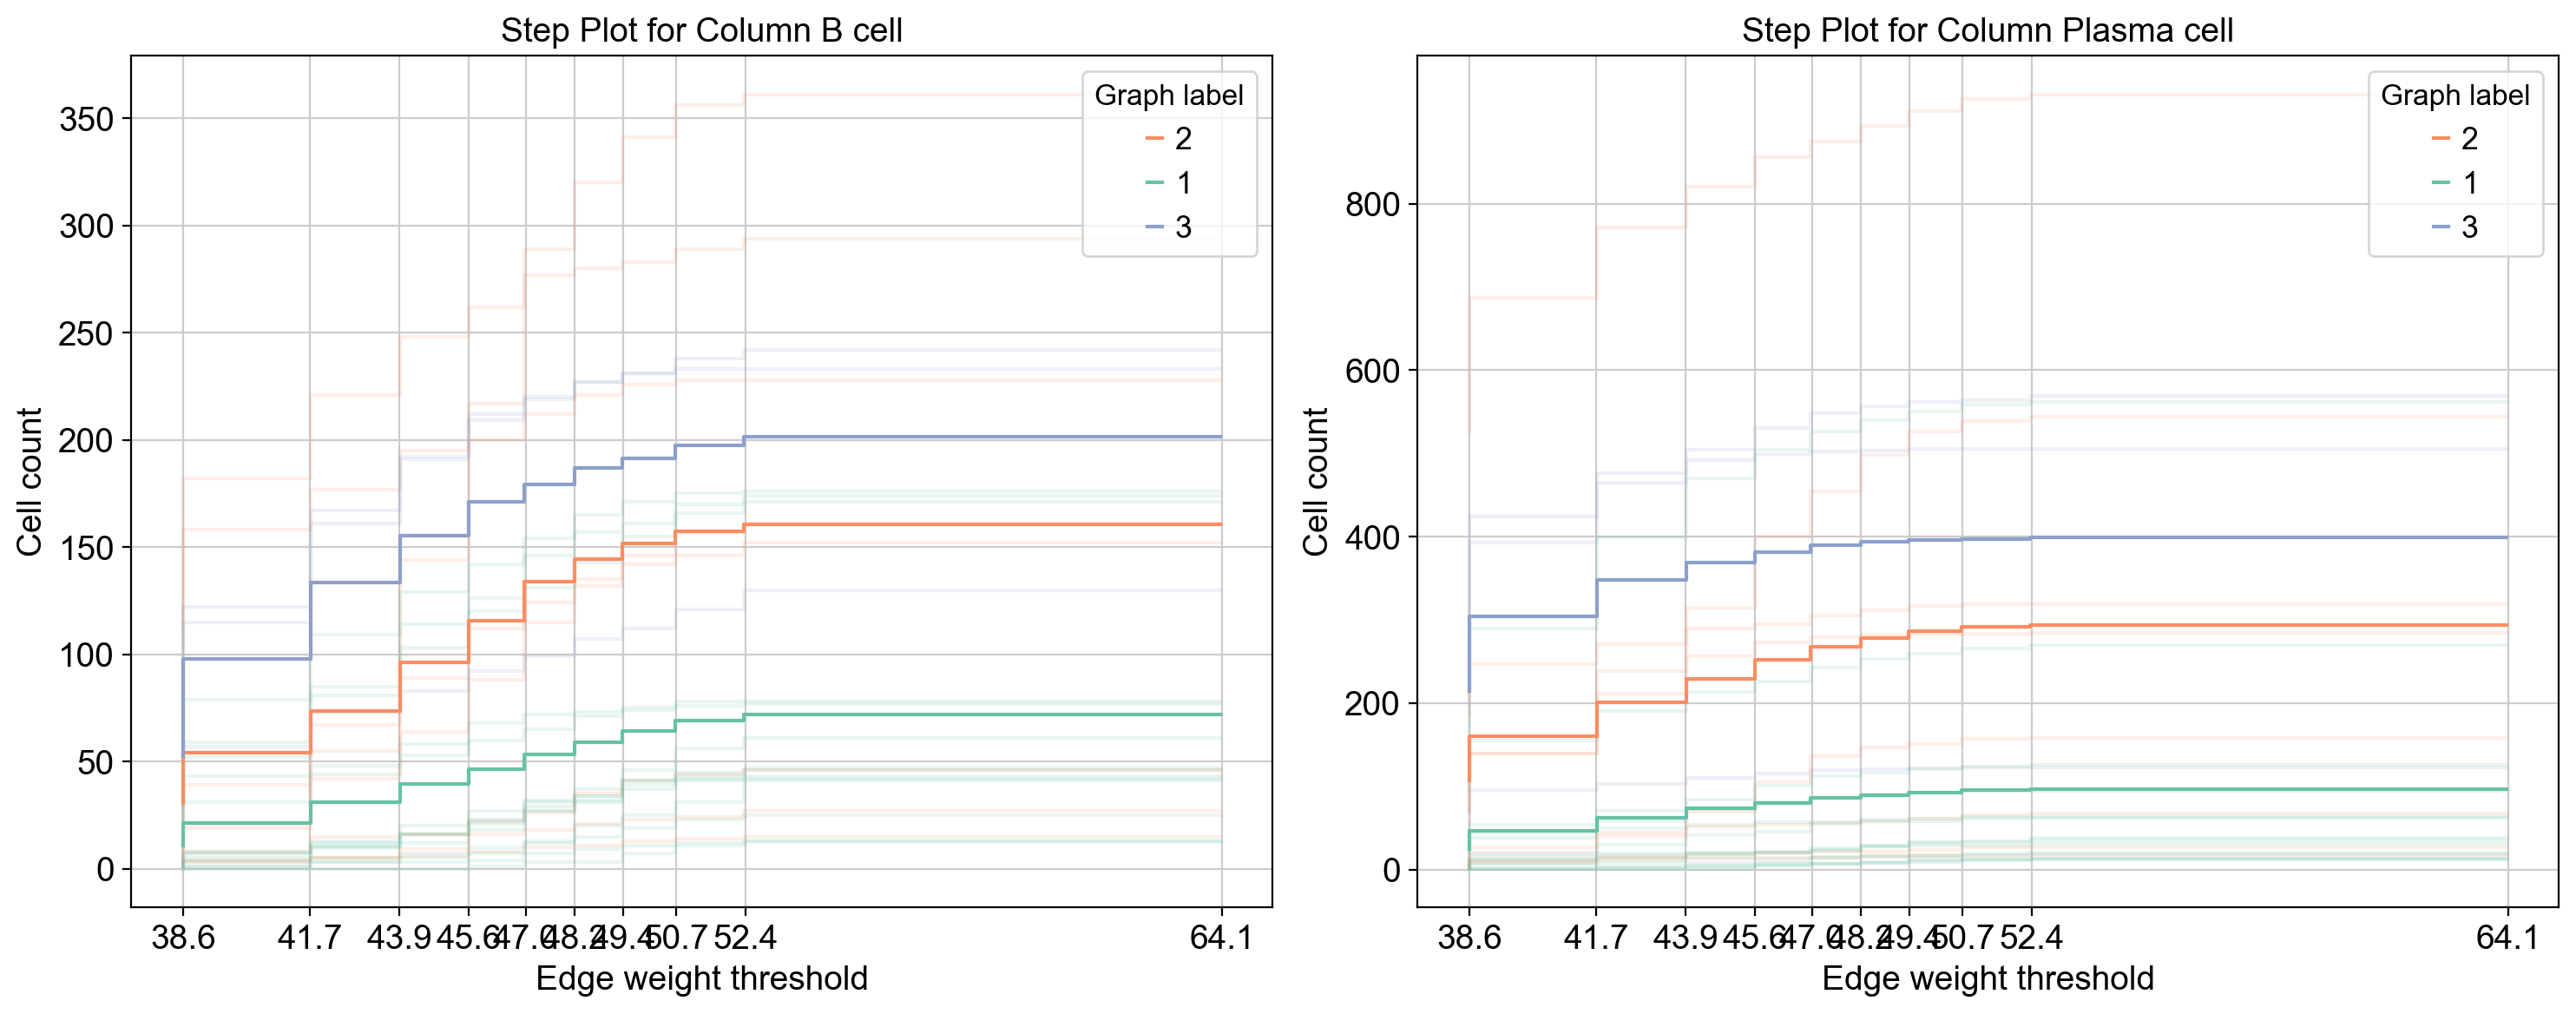

In [32]:
# if you want, remove the rightmost value from your plot because the change that happens (edge weight <50) is very minimal. 

gc.pl.filtration_curves.compare_conditions(
    adata=adata,
    node_labels=node_labels,
    metric_key=metric_key,
    palette="Set2",
    dpi=100,
    figsize=(20,6),
    save="filtration_curves_epithelial_clusters_v2.pdf"
)


# 4.2. Specific-cell-type subgraphs comparison

GraphCompass contains two graph distance metrics to compare cell-type-specific graphs between different conditions: portrait and diffusion methods. Both methods provide similarity scores between two networks of cells that represent two different conditions.

To calculate the metrics, we run gc.tl.distance.compare_condition (with method in ["diffusion", "portait"]).
To plot the results, we run gc.pl.distance.compare_condition.

Note: plotting function for diffusion method is still under development.

Compute distances between cell-type specific subgraphs using portrait method to compare conditions

In [36]:
# compute pairwise similarities between cell-type-specific graphs across samples
### results are stored in adata.uns["pairwise_similarities"]

# Note: in our case, the spatial graphs have been computed previously (to obtain the WL kernels), so we can set
## `compute_spatial_graphs` to False to save compute time. Otherwise, it should be set to True and 
## `kwargs_spatial_neighbors` should be set depending on the technology used to obtain the spatial data.

gc.tl.distance.compare_conditions(
    adata=adata,
    library_key='fov',
    cluster_key='CIPR_annotated_clusters',
    method="portrait",
    compute_spatial_graphs=False,
#     kwargs_spatial_neighbors={
#         'coord_type': 'generic',
#         'delaunay': True,  
#     }  
)

Spatial graphs were previously computed. Skipping computing spatial graphs 
Computing graph similarities...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [06:48<00:00, 18.55s/it]

Done!


22it [00:02,  9.16it/s]


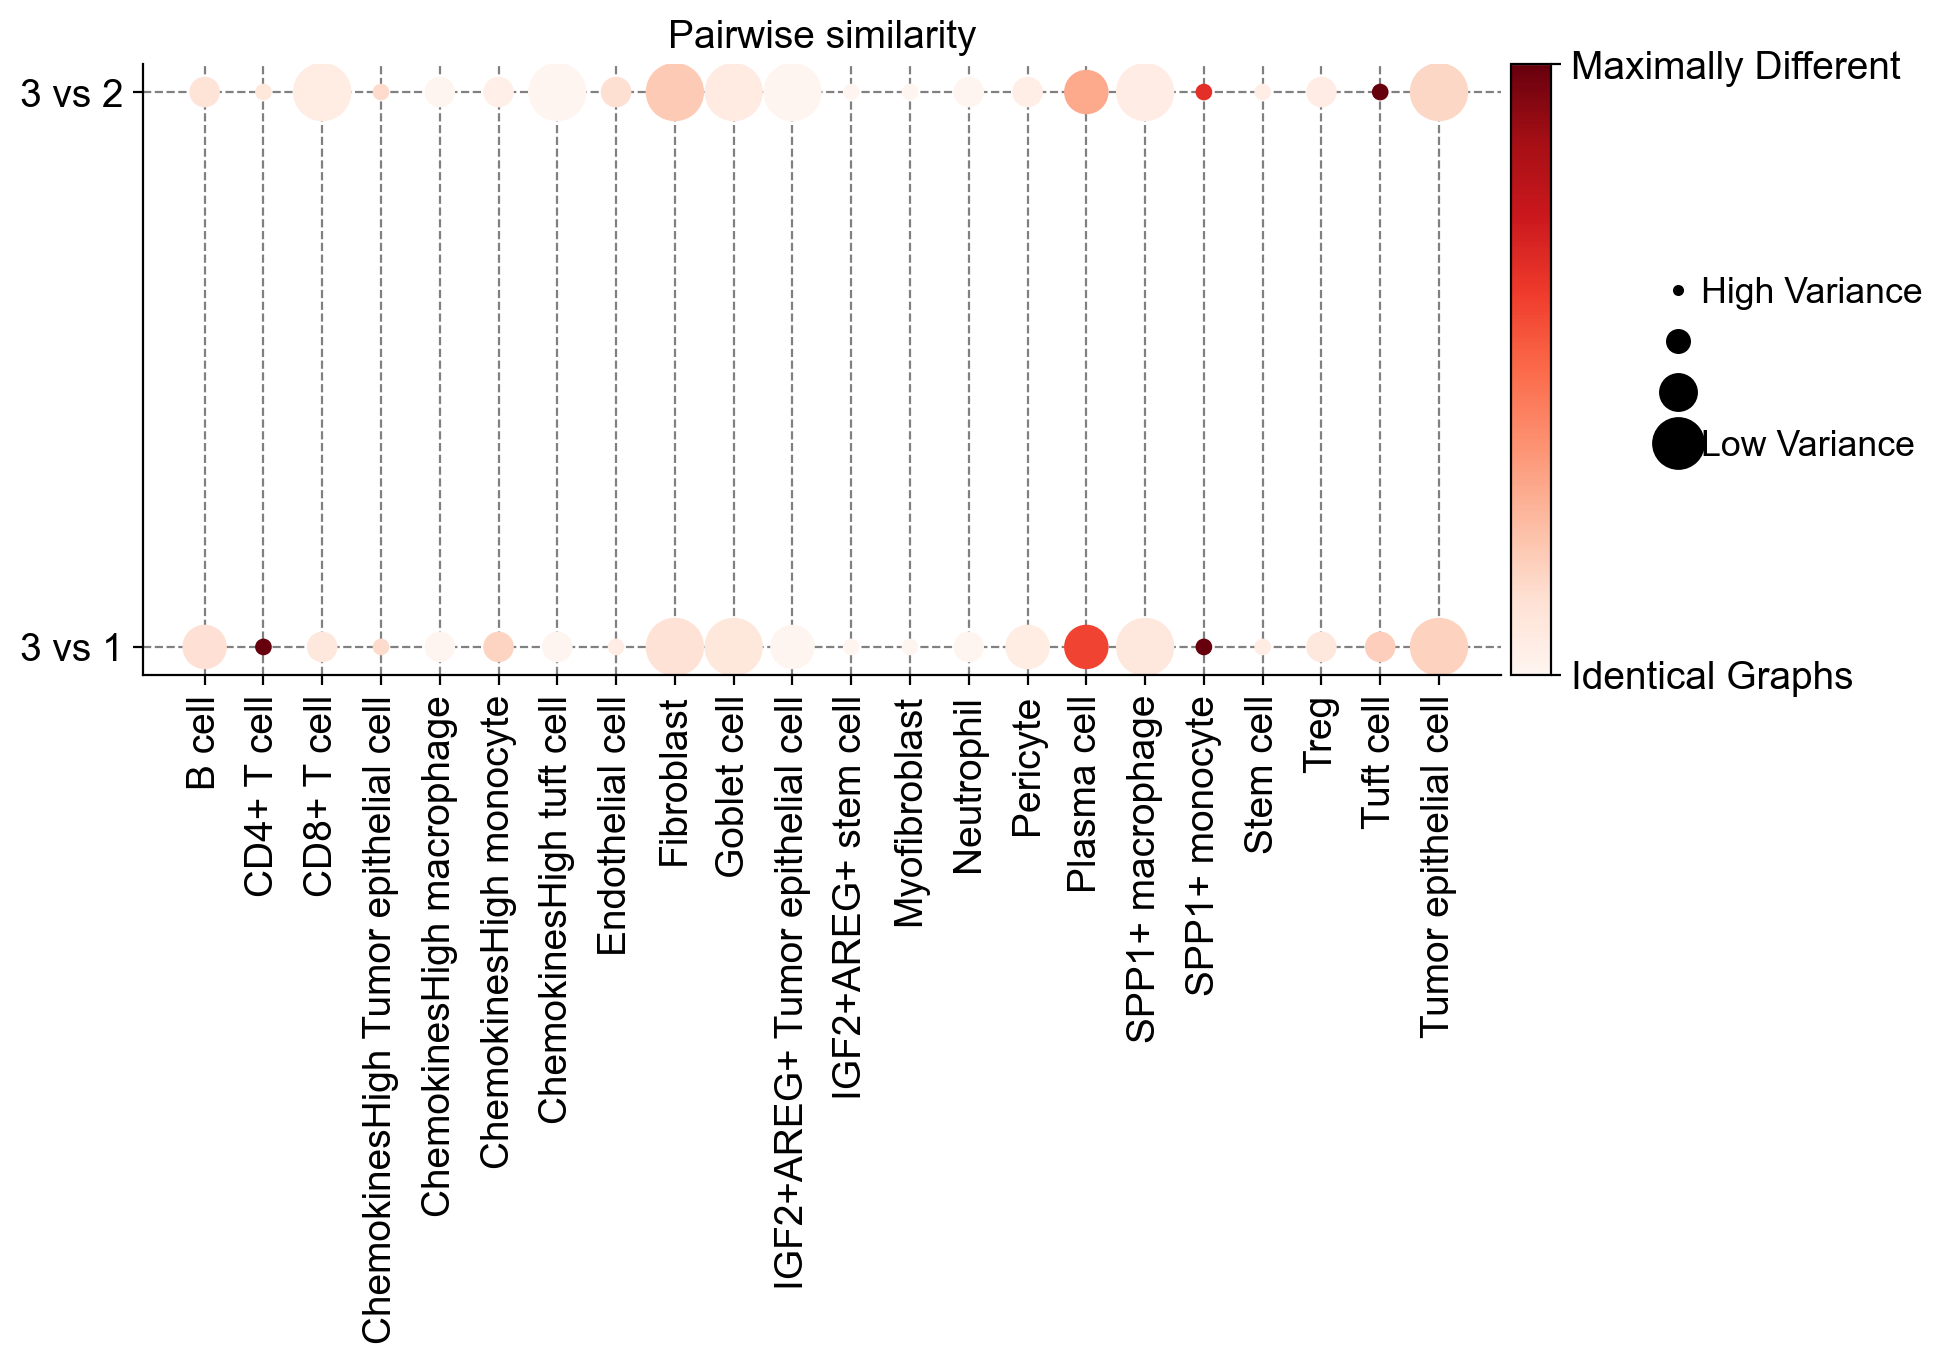

In [51]:
# Note: The size of the dot is indicative of the similarity score variance over samples. 
# The larger the dot size, the lower the score variance and the higher the score confidence is.

gc.pl.distance.compare_conditions(
    adata=adata,
    library_key='fov',
    condition_key='Epithelial_cluster',
    control_group=3,
    # add_ncells_and_density_plots=True,
    palette="Reds",
    dpi=100,
    figsize=(10,7), save="portrait.pdf"
)

# 4.3 - Differential NE analysis 

Neighborhood composition

In [53]:
annotation = "CIPR_annotated_clusters"
cell_type_levels = adata.obs[annotation].cat.categories

In [54]:
from tqdm import tqdm

count_list = []
for i, name in tqdm(enumerate(adata.obs_names)):
    row, col = adata.obsp['spatial_connectivities'][i, :].nonzero()
    count = adata.obs[annotation][col].value_counts()
    count_list.append(count)

neighborhood_composition = pd.DataFrame(count_list, index=adata.obs_names)

59436it [00:14, 4004.81it/s]


In [56]:
neighborhood_composition

CIPR_annotated_clusters,Plasma cell,SPP1+ macrophage,Fibroblast,SPP1+ monocyte,ChemokinesHigh tuft cell,Neutrophil,Stem cell,ChemokinesHigh Tumor epithelial cell,IGF2+AREG+ stem cell,IGF2+AREG+ Tumor epithelial cell,...,Myofibroblast,Tumor epithelial cell,Endothelial cell,B cell,CD4+ T cell,Goblet cell,CD8+ T cell,Treg,Pericyte,ChemokinesHigh macrophage
1_1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2_1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3_1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5_1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166_25,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2167_25,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2168_25,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2169_25,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
adata.uns['neighborhood_composition'] = neighborhood_composition

Neighborhood enrichment

In [59]:
adata.obs['library_id'] = adata.obs['fov'].copy()

In [60]:
zscore_list = []
count_list = []
celltype_names = []

for i in adata.obs.library_id.cat.categories:
    adata_sub = adata[adata.obs.library_id == i].copy()
    adata_sub.obs[annotation] = adata_sub.obs[annotation].astype('category')
    zscore, count = sq.gr.nhood_enrichment(
        adata_sub,
        cluster_key=annotation,
        copy=True,
        show_progress_bar=False,
    )
    
    ct_labels = adata_sub.obs[annotation].cat.categories
    del adata_sub
    
    celltype_names.append(ct_labels)
    zscore_list.append(zscore)
    count_list.append(count)

Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enrichment using `1` core(s)
Calculating neighborhood enr

In [63]:
assert len(zscore_list) == len(set(adata.obs['library_id']))

In [64]:
cell_type_levels = adata.obs[annotation].cat.categories

In [65]:
cell_type_levels

Index(['Fibroblast', 'Plasma cell', 'Pericyte', 'SPP1+ macrophage', 'Treg',
       'CD8+ T cell', 'Goblet cell', 'CD4+ T cell', 'B cell',
       'Endothelial cell', 'Tumor epithelial cell', 'Myofibroblast',
       'SPP1+ monocyte', 'ChemokinesHigh monocyte', 'Tuft cell',
       'IGF2+AREG+ Tumor epithelial cell', 'IGF2+AREG+ stem cell',
       'ChemokinesHigh Tumor epithelial cell', 'Stem cell', 'Neutrophil',
       'ChemokinesHigh tuft cell', 'ChemokinesHigh macrophage'],
      dtype='object')

In [72]:
cell_type_combinations = pd.DataFrame()

cell_types = pd.Series(cell_type_levels)
list_of_lists = np.repeat([cell_types], len(cell_type_levels), axis=0).reshape(-1,1).tolist()

cell_type_combinations['cell_type'] = cell_types.repeat(len(cell_types))
cell_type_combinations['interactor'] = [l[0] for l in list_of_lists]
cell_type_combinations['combination'] = cell_type_combinations['cell_type'].add('_' + cell_type_combinations['interactor'])
cell_type_combinations['dummy'] = cell_type_combinations['combination'].factorize()[0]
cell_type_combinations

,cell_type,interactor,combination,dummy
0,Fibroblast,Fibroblast,Fibroblast_Fibroblast,0
0,Fibroblast,Plasma cell,Fibroblast_Plasma cell,1
0,Fibroblast,Pericyte,Fibroblast_Pericyte,2
0,Fibroblast,SPP1+ macrophage,Fibroblast_SPP1+ macrophage,3
0,Fibroblast,Treg,Fibroblast_Treg,4
...,...,...,...,...
21,ChemokinesHigh macrophage,ChemokinesHigh Tumor epithelial cell,ChemokinesHigh macrophage_ChemokinesHigh Tumor...,479
21,ChemokinesHigh macrophage,Stem cell,ChemokinesHigh macrophage_Stem cell,480
21,ChemokinesHigh macrophage,Neutrophil,ChemokinesHigh macrophage_Neutrophil,481
21,ChemokinesHigh macrophage,ChemokinesHigh tuft cell,ChemokinesHigh macrophage_ChemokinesHigh tuft ...,482


In [73]:
n_celltypes = len(adata.obs[annotation].cat.categories)

In [74]:
n_celltypes

22

In [75]:
arr = np.array(cell_type_combinations.dummy).reshape(n_celltypes, n_celltypes)
celltypexcelltype = pd.DataFrame(arr, index=adata.obs[annotation].cat.categories,
                             columns=adata.obs[annotation].cat.categories)
celltypexcelltype

,Fibroblast,Plasma cell,Pericyte,SPP1+ macrophage,Treg,CD8+ T cell,Goblet cell,CD4+ T cell,B cell,Endothelial cell,...,SPP1+ monocyte,ChemokinesHigh monocyte,Tuft cell,IGF2+AREG+ Tumor epithelial cell,IGF2+AREG+ stem cell,ChemokinesHigh Tumor epithelial cell,Stem cell,Neutrophil,ChemokinesHigh tuft cell,ChemokinesHigh macrophage
Fibroblast,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
Plasma cell,22,23,24,25,26,27,28,29,30,31,...,34,35,36,37,38,39,40,41,42,43
Pericyte,44,45,46,47,48,49,50,51,52,53,...,56,57,58,59,60,61,62,63,64,65
SPP1+ macrophage,66,67,68,69,70,71,72,73,74,75,...,78,79,80,81,82,83,84,85,86,87
Treg,88,89,90,91,92,93,94,95,96,97,...,100,101,102,103,104,105,106,107,108,109
CD8+ T cell,110,111,112,113,114,115,116,117,118,119,...,122,123,124,125,126,127,128,129,130,131
Goblet cell,132,133,134,135,136,137,138,139,140,141,...,144,145,146,147,148,149,150,151,152,153
CD4+ T cell,154,155,156,157,158,159,160,161,162,163,...,166,167,168,169,170,171,172,173,174,175
B cell,176,177,178,179,180,181,182,183,184,185,...,188,189,190,191,192,193,194,195,196,197
Endothelial cell,198,199,200,201,202,203,204,205,206,207,...,210,211,212,213,214,215,216,217,218,219


Each sample/batch/subject is associated with one Z-score matrix. We return the upper triangular portion of each matrix and build a "subject x interactions" matrix called "df_wide".

In [76]:
df_list = []
sample_id = adata.obs.library_id.cat.categories

# continue with either the counts or Z-scores
# quant_data = count_list
quant_data = zscore_list

for i in range(len(quant_data)):
    df = pd.DataFrame()
    a = quant_data[i]
    upper = a[np.triu_indices(a.shape[0])]
    values = np.array(upper.reshape(-1,1))
    df['values'] = values.ravel()
    dummy_vars = celltypexcelltype.loc[celltypexcelltype.index.isin(celltype_names[i]),celltype_names[i]]
    dummy_vars = np.array(dummy_vars)
    dummy_vars = np.array(dummy_vars[np.triu_indices(dummy_vars.shape[0])].reshape(-1,1)).ravel()
    df['interaction_id'] = dummy_vars
    df.index = np.repeat(sample_id[i], df.shape[0]) 
    df_list.append(df)

print(len(df_list))

25


In [77]:
df_list

[       values  interaction_id
 1    8.734278               0
 1  -12.048519               1
 1    0.929000               2
 1   -1.151052               3
 1   -1.572563               4
 ..        ...             ...
 1   -0.265950             323
 1    5.402266             324
 1   -0.077693             345
 1    7.166124             346
 1   43.222435             368
 
 [153 rows x 2 columns],
        values  interaction_id
 10  14.649545               0
 10   1.146276               1
 10   8.206619               2
 10   4.109032               3
 10   1.623114               4
 ..        ...             ...
 10  -0.926844             415
 10  -0.458012             416
 10  -0.089803             437
 10  -0.095298             438
 10        NaN             460
 
 [190 rows x 2 columns],
       values  interaction_id
 11  9.788702               0
 11 -2.418628               1
 11  5.555077               2
 11  1.410510               3
 11  5.444964               4
 ..       ...         

In [78]:
df_long = pd.concat(df_list)

# replace dummy factors with cell type labels
label_dict = {'interaction_id': dict(zip(cell_type_combinations['dummy'], cell_type_combinations['combination']))}
df_long.replace(label_dict, inplace=True)
df_long

# melt the matrix  
df_wide = df_long.pivot(columns='interaction_id', values='values')
df_wide[np.isnan(df_wide)] = 0
# df_wide

In [79]:
df_wide

interaction_id,B cell_B cell,B cell_ChemokinesHigh Tumor epithelial cell,B cell_ChemokinesHigh macrophage,B cell_ChemokinesHigh monocyte,B cell_ChemokinesHigh tuft cell,B cell_Endothelial cell,B cell_IGF2+AREG+ Tumor epithelial cell,B cell_IGF2+AREG+ stem cell,B cell_Myofibroblast,B cell_Neutrophil,...,Tumor epithelial cell_ChemokinesHigh monocyte,Tumor epithelial cell_ChemokinesHigh tuft cell,Tumor epithelial cell_IGF2+AREG+ Tumor epithelial cell,Tumor epithelial cell_IGF2+AREG+ stem cell,Tumor epithelial cell_Myofibroblast,Tumor epithelial cell_Neutrophil,Tumor epithelial cell_SPP1+ monocyte,Tumor epithelial cell_Stem cell,Tumor epithelial cell_Tuft cell,Tumor epithelial cell_Tumor epithelial cell
1,4.453711,0.000000,0.000000,2.518092,0.000000,-1.878330,-1.150333,-4.664897,-2.141296,0.000000,...,9.066785,0.000000,-0.775214,-3.163872,-3.594920,0.000000,4.110627,0.000000,3.687424,16.897969
10,2.329253,0.325934,0.000000,0.485127,-0.131507,0.248239,0.000000,4.554240,1.961238,-0.278960,...,-1.030325,-0.820477,0.000000,2.379445,-2.345390,-1.003657,-1.740924,-1.780495,2.572108,8.866879
11,6.695349,-1.863413,0.000000,-0.637708,0.000000,-1.139390,0.000000,-0.422302,-0.604203,0.000000,...,-1.995397,0.000000,0.000000,0.909262,-3.838748,0.000000,-1.323210,0.160760,4.589443,10.452052
12,1.704808,-1.708747,0.000000,-0.994852,0.000000,0.550440,0.000000,-0.267060,-0.375334,-0.515598,...,-0.283793,0.000000,0.000000,3.779818,-1.658218,-2.450256,-4.372667,-0.527651,2.896865,9.471018
13,-0.293671,-1.135869,0.000000,-0.748540,-0.127515,0.847097,0.000000,-0.346699,4.227224,0.000000,...,-2.252118,-0.921365,0.000000,0.819417,-0.655843,0.000000,-1.617399,1.298773,4.215551,5.606335
14,-0.421503,-0.636640,2.058303,-0.154012,0.000000,-1.121794,0.000000,-0.196282,-0.579746,1.100353,...,-3.005809,0.000000,0.000000,0.290562,-2.587999,-3.369377,-1.573519,1.331916,1.496259,8.851474
15,4.510980,-1.612511,0.000000,0.151810,0.000000,0.196408,0.000000,-0.961634,-1.448554,0.000000,...,2.220503,0.000000,0.000000,3.636671,-2.087872,0.000000,-0.724754,2.725138,9.575076,17.113196
16,4.448963,-4.305758,0.000000,1.569023,-0.623136,0.340207,0.000000,0.526120,-1.150949,-0.432919,...,7.518131,-0.407203,0.000000,0.482825,-1.428068,0.262823,16.162964,-0.511682,5.841780,15.693625
17,3.026820,-0.777628,0.000000,-0.133763,-0.207001,-1.016127,0.000000,-0.737407,-0.498540,-0.579278,...,-0.448881,0.115799,0.000000,2.530812,-1.758362,-2.480907,-5.060948,2.343372,2.274736,6.023166
18,3.554774,-1.640649,-0.411780,-0.026011,-0.711356,-2.117124,0.000000,-0.830915,-1.610402,-0.593742,...,1.721544,-1.320773,0.000000,5.062817,-3.020565,-1.055547,4.237576,0.000000,1.062371,11.943109


In [80]:
adata.uns['celltype_interaction'] = df_wide

In [81]:
nan_indices = df_wide.isna().any()
print(sum(nan_indices.astype(int)))

0


Experiment design

In [82]:
#Extract the batch and condition ('Epithelial cluster' or 'Recurrence') column from the AnnData object.

group = adata.obs[['library_id','fov','Epithelial_cluster']].copy()  # change as needed
group.drop_duplicates(inplace=True)
group.set_index('library_id', inplace=True)
group

,fov,Epithelial_cluster
library_id,,
1,1,2
2,2,1
3,3,3
4,4,1
5,5,1
6,6,2
7,7,1
8,8,1
9,9,2


In [84]:
print(group.fov.cat.categories)
print(group.Epithelial_cluster.cat.categories)

Index(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '23', '24', '25', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')
Index([1, 2, 3], dtype='int64')


In [85]:
condition = group.Epithelial_cluster  # change as needed
patient = group.fov  # change as needed

In [86]:
interaction_mat = adata.uns['celltype_interaction']
interaction_mat['condition'] = condition
interaction_mat['subject_id'] = patient

In [87]:
interaction_mat

interaction_id,B cell_B cell,B cell_ChemokinesHigh Tumor epithelial cell,B cell_ChemokinesHigh macrophage,B cell_ChemokinesHigh monocyte,B cell_ChemokinesHigh tuft cell,B cell_Endothelial cell,B cell_IGF2+AREG+ Tumor epithelial cell,B cell_IGF2+AREG+ stem cell,B cell_Myofibroblast,B cell_Neutrophil,...,Tumor epithelial cell_IGF2+AREG+ Tumor epithelial cell,Tumor epithelial cell_IGF2+AREG+ stem cell,Tumor epithelial cell_Myofibroblast,Tumor epithelial cell_Neutrophil,Tumor epithelial cell_SPP1+ monocyte,Tumor epithelial cell_Stem cell,Tumor epithelial cell_Tuft cell,Tumor epithelial cell_Tumor epithelial cell,condition,subject_id
1,4.453711,0.000000,0.000000,2.518092,0.000000,-1.878330,-1.150333,-4.664897,-2.141296,0.000000,...,-0.775214,-3.163872,-3.594920,0.000000,4.110627,0.000000,3.687424,16.897969,2,1
10,2.329253,0.325934,0.000000,0.485127,-0.131507,0.248239,0.000000,4.554240,1.961238,-0.278960,...,0.000000,2.379445,-2.345390,-1.003657,-1.740924,-1.780495,2.572108,8.866879,1,10
11,6.695349,-1.863413,0.000000,-0.637708,0.000000,-1.139390,0.000000,-0.422302,-0.604203,0.000000,...,0.000000,0.909262,-3.838748,0.000000,-1.323210,0.160760,4.589443,10.452052,2,11
12,1.704808,-1.708747,0.000000,-0.994852,0.000000,0.550440,0.000000,-0.267060,-0.375334,-0.515598,...,0.000000,3.779818,-1.658218,-2.450256,-4.372667,-0.527651,2.896865,9.471018,2,12
13,-0.293671,-1.135869,0.000000,-0.748540,-0.127515,0.847097,0.000000,-0.346699,4.227224,0.000000,...,0.000000,0.819417,-0.655843,0.000000,-1.617399,1.298773,4.215551,5.606335,1,13
14,-0.421503,-0.636640,2.058303,-0.154012,0.000000,-1.121794,0.000000,-0.196282,-0.579746,1.100353,...,0.000000,0.290562,-2.587999,-3.369377,-1.573519,1.331916,1.496259,8.851474,2,14
15,4.510980,-1.612511,0.000000,0.151810,0.000000,0.196408,0.000000,-0.961634,-1.448554,0.000000,...,0.000000,3.636671,-2.087872,0.000000,-0.724754,2.725138,9.575076,17.113196,3,15
16,4.448963,-4.305758,0.000000,1.569023,-0.623136,0.340207,0.000000,0.526120,-1.150949,-0.432919,...,0.000000,0.482825,-1.428068,0.262823,16.162964,-0.511682,5.841780,15.693625,1,16
17,3.026820,-0.777628,0.000000,-0.133763,-0.207001,-1.016127,0.000000,-0.737407,-0.498540,-0.579278,...,0.000000,2.530812,-1.758362,-2.480907,-5.060948,2.343372,2.274736,6.023166,2,17
18,3.554774,-1.640649,-0.411780,-0.026011,-0.711356,-2.117124,0.000000,-0.830915,-1.610402,-0.593742,...,0.000000,5.062817,-3.020565,-1.055547,4.237576,0.000000,1.062371,11.943109,1,18


In [88]:
sum(interaction_mat.condition.isna())

0

In [89]:
interaction_mat = pd.melt(interaction_mat, id_vars = ['condition','subject_id'])
interaction_mat.shape

(6250, 4)

In [90]:
interaction_mat

,condition,subject_id,interaction_id,value
0,2,1,B cell_B cell,4.453711
1,1,10,B cell_B cell,2.329253
2,2,11,B cell_B cell,6.695349
3,2,12,B cell_B cell,1.704808
4,1,13,B cell_B cell,-0.293671
...,...,...,...,...
6245,1,5,Tumor epithelial cell_Tumor epithelial cell,4.091147
6246,2,6,Tumor epithelial cell_Tumor epithelial cell,4.917156
6247,1,7,Tumor epithelial cell_Tumor epithelial cell,9.844657
6248,1,8,Tumor epithelial cell_Tumor epithelial cell,7.689562


Prepare experiment

In [227]:
condition

library_id
1     2
2     1
3     3
4     1
5     1
6     2
7     1
8     1
9     2
10    1
11    2
12    2
13    1
14    2
15    3
16    1
17    2
18    1
19    1
20    1
21    3
22    1
23    2
24    1
25    1
Name: Epithelial_cluster, dtype: category
Categories (3, int64): [1, 2, 3]

In [228]:
len(condition)

25

In [221]:
cell_type_interaction_mat = interaction_mat.copy()

In [230]:
cell_type_interaction_mat['subject_id'] = cell_type_interaction_mat['subject_id'].astype('category')
cell_type_interaction_mat['condition'] = cell_type_interaction_mat['condition'].astype('category')
cell_type_interaction_mat['condition'] = cell_type_interaction_mat['condition'].cat.reorder_categories([3, 1, 2], ordered=True)
cell_type_interaction_mat.head()

,condition,subject_id,interaction_id,value
0,2,1,B cell_B cell,4.453711
1,1,10,B cell_B cell,2.329253
2,2,11,B cell_B cell,6.695349
3,2,12,B cell_B cell,1.704808
4,1,13,B cell_B cell,-0.293671
...,...,...,...,...
6245,1,5,Tumor epithelial cell_Tumor epithelial cell,4.091147
6246,2,6,Tumor epithelial cell_Tumor epithelial cell,4.917156
6247,1,7,Tumor epithelial cell_Tumor epithelial cell,9.844657
6248,1,8,Tumor epithelial cell_Tumor epithelial cell,7.689562


(Generalized) Linear Model

In [231]:
import statsmodels.api as sm

In [232]:
# install the development version: pip install git+https://github.com/has2k1/plotnine.git

from plotnine import ggplot, aes, geom_bar, coord_flip, theme_minimal, theme_bw, facet_grid, labs, theme

In [233]:
model = sm.formula.ols(formula='value ~ subject_id + interaction_id * condition', data=cell_type_interaction_mat).fit()
                       

In [234]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     7.303
Date:                Wed, 06 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:42:12   Log-Likelihood:                -13523.
No. Observations:                6250   AIC:                         2.859e+04
Df Residuals:                    5478   BIC:                         3.379e+04
Df Model:                         771                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================================
                                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                  -2.354e+11   1.39e+12     -0.169      0.866   -2.97e+12     2.5e+12
subject_id[T.10]                                                                                           -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.11]                                                                                              -0.0300      0.204     -0.147      0.883      -0.429       0.369
subject_id[T.12]                                                                                              -0.0966      0.221     -0.438      0.661      -0.529       0.336
subject_id[T.13]                                                                                           -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.14]                                                                                              -0.1094      0.204     -0.538      0.591      -0.509       0.290
subject_id[T.15]                                                                                            2.354e+11   1.39e+12      0.169      0.866    -2.5e+12    2.97e+12
subject_id[T.16]                                                                                           -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.17]                                                                                               0.0897      0.211      0.426      0.670      -0.323       0.503
subject_id[T.18]                                                                                           -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.19]                                                                                           -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.2]                                                                                            -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.20]                                                                                           -2.733e+11   8.67e+11     -0.315      0.753   -1.97e+12    1.43e+12
subject_id[T.21]                                                                                            2.354e+11   1.39e+12      0.169      0.866    -2.5e+12    2.97e+12
subject_id[T.22]                                                                                           -

Inspect significant coefficients

In [235]:
(model.pvalues < 0.05).sum()

265

In [237]:
significant_coef_names = model.params[model.pvalues < 0.05].index.tolist()
print(significant_coef_names)

['subject_id[T.6]', 'interaction_id[T.B cell_ChemokinesHigh Tumor epithelial cell]', 'interaction_id[T.B cell_ChemokinesHigh macrophage]', 'interaction_id[T.B cell_ChemokinesHigh monocyte]', 'interaction_id[T.B cell_ChemokinesHigh tuft cell]', 'interaction_id[T.B cell_Endothelial cell]', 'interaction_id[T.B cell_IGF2+AREG+ Tumor epithelial cell]', 'interaction_id[T.B cell_IGF2+AREG+ stem cell]', 'interaction_id[T.B cell_Myofibroblast]', 'interaction_id[T.B cell_Neutrophil]', 'interaction_id[T.B cell_SPP1+ monocyte]', 'interaction_id[T.B cell_Stem cell]', 'interaction_id[T.B cell_Tuft cell]', 'interaction_id[T.B cell_Tumor epithelial cell]', 'interaction_id[T.CD4+ T cell_CD4+ T cell]', 'interaction_id[T.CD4+ T cell_ChemokinesHigh Tumor epithelial cell]', 'interaction_id[T.CD4+ T cell_ChemokinesHigh macrophage]', 'interaction_id[T.CD4+ T cell_ChemokinesHigh monocyte]', 'interaction_id[T.CD4+ T cell_ChemokinesHigh tuft cell]', 'interaction_id[T.CD4+ T cell_Endothelial cell]', 'interaction

In [238]:
signif_coefs = model.params[model.pvalues < 0.05]
ggdat = pd.DataFrame({'coef_label': signif_coefs.index, 'pvals': model.pvalues[model.pvalues < 0.05]})
ggdat

,coef_label,pvals
subject_id[T.6],subject_id[T.6],2.299114e-02
interaction_id[T.B cell_ChemokinesHigh Tumor epithelial cell],interaction_id[T.B cell_ChemokinesHigh Tumor e...,8.259723e-05
interaction_id[T.B cell_ChemokinesHigh macrophage],interaction_id[T.B cell_ChemokinesHigh macroph...,3.032047e-03
interaction_id[T.B cell_ChemokinesHigh monocyte],interaction_id[T.B cell_ChemokinesHigh monocyte],1.634370e-03
interaction_id[T.B cell_ChemokinesHigh tuft cell],interaction_id[T.B cell_ChemokinesHigh tuft cell],2.440530e-03
...,...,...
interaction_id[T.Plasma cell_Goblet cell]:condition[T.2],interaction_id[T.Plasma cell_Goblet cell]:cond...,1.822065e-02
interaction_id[T.Plasma cell_Plasma cell]:condition[T.2],interaction_id[T.Plasma cell_Plasma cell]:cond...,5.014819e-07
interaction_id[T.Plasma cell_Tumor epithelial cell]:condition[T.2],interaction_id[T.Plasma cell_Tumor epithelial ...,2.495381e-03
interaction_id[T.SPP1+ macrophage_Tumor epithelial cell]:condition[T.2],interaction_id[T.SPP1+ macrophage_Tumor epithe...,1.876852e-02


In [239]:
ggdat = ggdat[ggdat['coef_label'].str.contains('condition')]
ggdat

,coef_label,pvals
interaction_id[T.B cell_Tumor epithelial cell]:condition[T.1],interaction_id[T.B cell_Tumor epithelial cell]...,1.511489e-02
interaction_id[T.CD4+ T cell_Tumor epithelial cell]:condition[T.1],interaction_id[T.CD4+ T cell_Tumor epithelial ...,2.972845e-02
interaction_id[T.CD8+ T cell_CD8+ T cell]:condition[T.1],interaction_id[T.CD8+ T cell_CD8+ T cell]:cond...,1.653979e-02
interaction_id[T.CD8+ T cell_SPP1+ monocyte]:condition[T.1],interaction_id[T.CD8+ T cell_SPP1+ monocyte]:c...,4.110783e-02
interaction_id[T.ChemokinesHigh Tumor epithelial cell_ChemokinesHigh Tumor epithelial cell]:condition[T.1],interaction_id[T.ChemokinesHigh Tumor epitheli...,8.647197e-03
interaction_id[T.ChemokinesHigh monocyte_ChemokinesHigh monocyte]:condition[T.1],interaction_id[T.ChemokinesHigh monocyte_Chemo...,8.268778e-03
interaction_id[T.ChemokinesHigh tuft cell_ChemokinesHigh tuft cell]:condition[T.1],interaction_id[T.ChemokinesHigh tuft cell_Chem...,3.648826e-02
interaction_id[T.Fibroblast_Fibroblast]:condition[T.1],interaction_id[T.Fibroblast_Fibroblast]:condit...,3.259527e-04
interaction_id[T.Fibroblast_Plasma cell]:condition[T.1],interaction_id[T.Fibroblast_Plasma cell]:condi...,2.452318e-03
interaction_id[T.Fibroblast_SPP1+ macrophage]:condition[T.1],interaction_id[T.Fibroblast_SPP1+ macrophage]:...,1.391730e-02


In [240]:
# extract conditions from DataFrame index
ggdat['condition'] = ggdat.index.str.extract(r':condition\[T\.([^\]]+)\]')[0].values
# extract cell pairs from DataFrame index
ggdat['coef_label'] = ggdat.index.str.extract(r'interaction_id\[T\.([^\]]+)\]:condition')[0].values
#ggdat

In [241]:
ggdat['neg_log_pvals'] = -np.log10(ggdat['pvals'])
ggdat

,coef_label,pvals,condition,neg_log_pvals
interaction_id[T.B cell_Tumor epithelial cell]:condition[T.1],B cell_Tumor epithelial cell,1.511489e-02,1,1.820595
interaction_id[T.CD4+ T cell_Tumor epithelial cell]:condition[T.1],CD4+ T cell_Tumor epithelial cell,2.972845e-02,1,1.526828
interaction_id[T.CD8+ T cell_CD8+ T cell]:condition[T.1],CD8+ T cell_CD8+ T cell,1.653979e-02,1,1.781470
interaction_id[T.CD8+ T cell_SPP1+ monocyte]:condition[T.1],CD8+ T cell_SPP1+ monocyte,4.110783e-02,1,1.386076
interaction_id[T.ChemokinesHigh Tumor epithelial cell_ChemokinesHigh Tumor epithelial cell]:condition[T.1],ChemokinesHigh Tumor epithelial cell_Chemokine...,8.647197e-03,1,2.063125
interaction_id[T.ChemokinesHigh monocyte_ChemokinesHigh monocyte]:condition[T.1],ChemokinesHigh monocyte_ChemokinesHigh monocyte,8.268778e-03,1,2.082559
interaction_id[T.ChemokinesHigh tuft cell_ChemokinesHigh tuft cell]:condition[T.1],ChemokinesHigh tuft cell_ChemokinesHigh tuft cell,3.648826e-02,1,1.437847
interaction_id[T.Fibroblast_Fibroblast]:condition[T.1],Fibroblast_Fibroblast,3.259527e-04,1,3.486845
interaction_id[T.Fibroblast_Plasma cell]:condition[T.1],Fibroblast_Plasma cell,2.452318e-03,1,2.610423
interaction_id[T.Fibroblast_SPP1+ macrophage]:condition[T.1],Fibroblast_SPP1+ macrophage,1.391730e-02,1,1.856445


In [242]:
ggdat = ggdat.dropna(subset=['coef_label'])

In [243]:
ggdat

,coef_label,pvals,condition,neg_log_pvals
interaction_id[T.B cell_Tumor epithelial cell]:condition[T.1],B cell_Tumor epithelial cell,1.511489e-02,1,1.820595
interaction_id[T.CD4+ T cell_Tumor epithelial cell]:condition[T.1],CD4+ T cell_Tumor epithelial cell,2.972845e-02,1,1.526828
interaction_id[T.CD8+ T cell_CD8+ T cell]:condition[T.1],CD8+ T cell_CD8+ T cell,1.653979e-02,1,1.781470
interaction_id[T.CD8+ T cell_SPP1+ monocyte]:condition[T.1],CD8+ T cell_SPP1+ monocyte,4.110783e-02,1,1.386076
interaction_id[T.ChemokinesHigh Tumor epithelial cell_ChemokinesHigh Tumor epithelial cell]:condition[T.1],ChemokinesHigh Tumor epithelial cell_Chemokine...,8.647197e-03,1,2.063125
interaction_id[T.ChemokinesHigh monocyte_ChemokinesHigh monocyte]:condition[T.1],ChemokinesHigh monocyte_ChemokinesHigh monocyte,8.268778e-03,1,2.082559
interaction_id[T.ChemokinesHigh tuft cell_ChemokinesHigh tuft cell]:condition[T.1],ChemokinesHigh tuft cell_ChemokinesHigh tuft cell,3.648826e-02,1,1.437847
interaction_id[T.Fibroblast_Fibroblast]:condition[T.1],Fibroblast_Fibroblast,3.259527e-04,1,3.486845
interaction_id[T.Fibroblast_Plasma cell]:condition[T.1],Fibroblast_Plasma cell,2.452318e-03,1,2.610423
interaction_id[T.Fibroblast_SPP1+ macrophage]:condition[T.1],Fibroblast_SPP1+ macrophage,1.391730e-02,1,1.856445


In [248]:
from plotnine import *
from plotnine.data import diamonds
from matplotlib import pyplot as plt

p = (ggplot(ggdat, aes(x='coef_label', y='neg_log_pvals', fill='condition')) 
    + geom_bar(stat='identity', position='dodge', size=30)
    + coord_flip()
    + theme_minimal(base_size=8)
    + facet_grid('.~condition')
    + labs(x='celltype-celltype neighborhood enrichment')
    + theme(figure_size=(6, 6)))

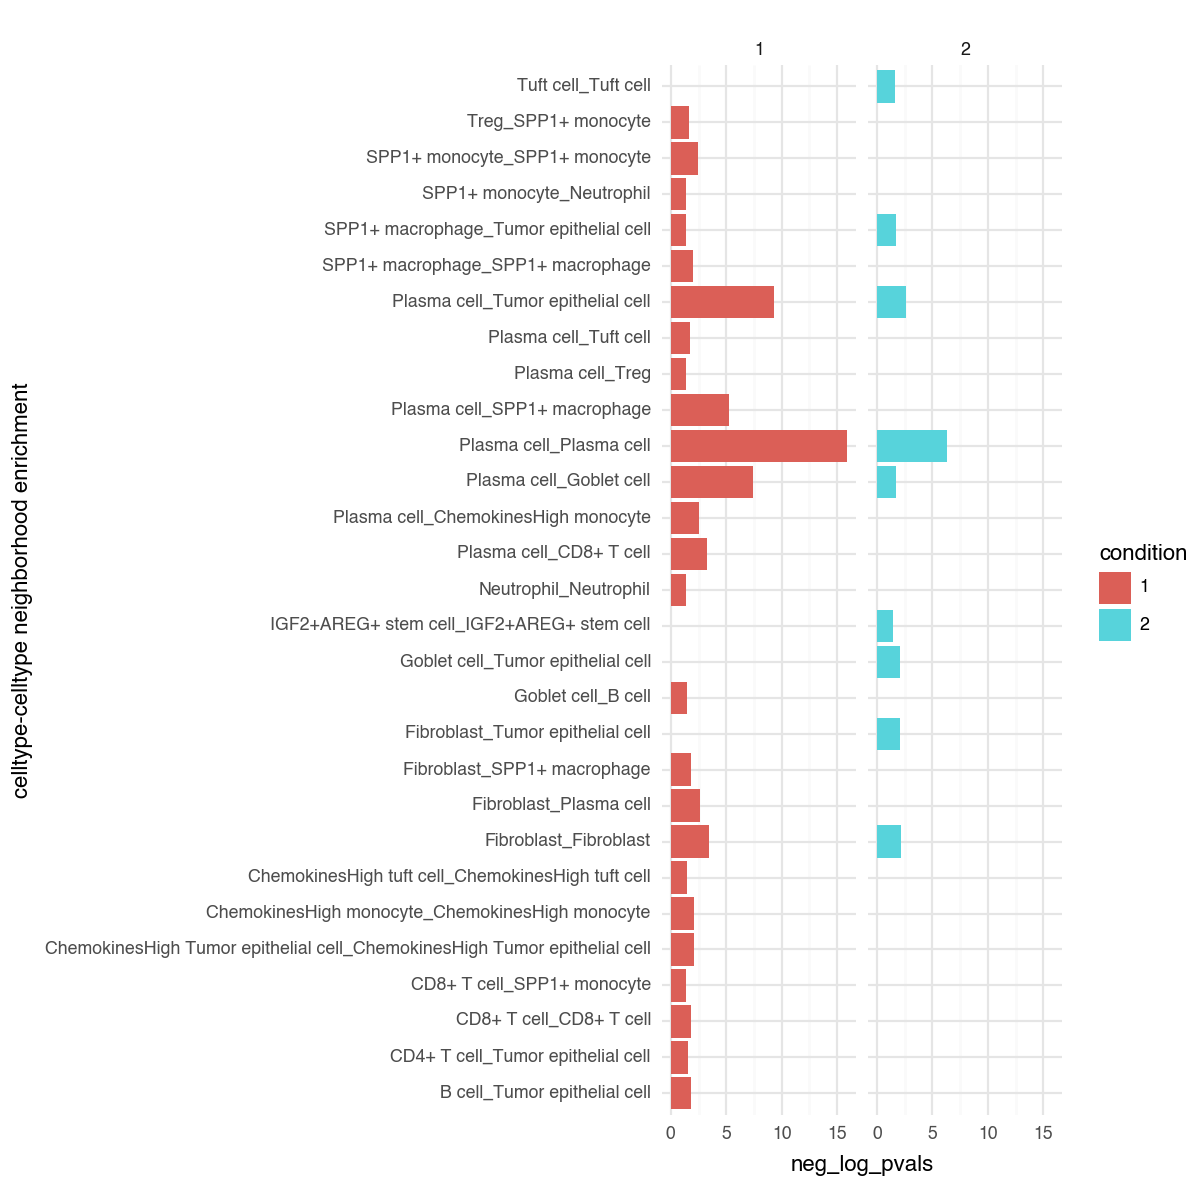

<Figure Size: (600 x 600)>

In [249]:
p

In [250]:
p.save(filename = 'DiffNE_epithelial_clusters_vscluster3_p005.pdf', dpi=300)

# Save adata object

Had some issues to sabve adata object after NE analysis. Delete the correspondent slots in the adata.uns to save the object.

In [251]:
adata3 = adata.copy()

In [ ]:
adata3

In [ ]:
del adata3.uns['CIPR_annotated_clusters_cluster_cellcharter_v1_enrichment']
del adata3.uns['CIPR_annotated_clusters_cluster_cellcharter_v2_enrichment']
del adata3.uns['CIPR_annotated_clusters_cluster_cellcharter_v3_enrichment']
del adata3.uns['CIPR_annotated_clusters_cluster_cellcharter_v4_enrichment']
del adata3.uns['CIPR_annotated_clusters_cluster_cellcharter_final_enrichment']
del adata3.uns['CIPR_annotated_clusters_Epithelial_cluster_diff_nhood_enrichment']
del adata3.uns['cluster_cellcharter_final_nhood_enrichment']
del adata3.uns['cluster_cellcharter_final_Epithelial_cluster_diff_nhood_enrichment']


In [ ]:
adata3

In [252]:
adata3.write('./adata_fov_subset_integration.h5ad')